<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TestingNVPExtensionGaussianLikelihood_Hessians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     \ 11.0MB 1.2MB/s


In [0]:
import corner

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

W0516 04:13:21.272316 140614245906304 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [6]:
generator_path   = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path     = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
nvp_func_path    = './gdrive/My Drive/MPM/modules/gauss3b/nvp-final4'
minima_path      = './gdrive/My Drive/MPM/modules/gauss3b/minima/'
plot_path        = './gdrive/My Drive/MPM/modules/gauss3b/plots/'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/nvp-final4/

assets	saved_model.pb	tfhub_module.pb  variables


In [0]:

from tensorflow.contrib.opt import ScipyOptimizerInterface

In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [26]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [22]:
#finding EL2O 'by hand'
tf.reset_default_graph()


batch_size  = 64
hidden_size = 10
sigma_n     = 0.1
n_channels  = 1
data_dim    = 28*28

sample_size_z = 64
lr            = tf.placeholder_with_default(0.001,shape=[])

encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)
grad_opt      = tf.train.GradientDescentOptimizer(learning_rate=lr)

def get_prior():
  return tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0, name ='prior')

prior = get_prior()

# ----------------------------------------------------------#


# uncorrupted data

prior_samples = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

x_tr          = tf.placeholder(shape=[batch_size,data_dim,n_channels], dtype=tf.float32)

encoded_data  = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma     = tf.split(encoded_data, 2, axis=-1)
sigma         = tf.nn.softplus(sigma) + 0.0001

approx_posterior_vae = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[-1,data_dim,1])

# uncoruppted data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
recon             = likelihood_vae.mean()

#test sample from prior
prior_sample      = prior.sample(sample_size_z)
sample_liklogits  = tf.reshape(generator(prior_samples),[-1,data_dim,n_channels])

sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()

# ----------------------------------------------------------#



# -----------train NVP ----------------------#

# nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]
# 

# def get_nvp():
  
#   p1 = np.arange(0,hidden_size//2)
#   p2 = np.arange(hidden_size//2,hidden_size)
#   perm=np.concatenate((p2,p1))
  
#   base_dis = get_prior()
  
#   chain = []
  
#   for i,s in enumerate(nvp_size):
#     chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
#     chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

#   nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
#   return nvp

# def nvp_module_spec():
#     z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     sample_size  = tf.placeholder(tf.int32, shape=[])
#     u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     nvp_         = get_nvp()
#     log_prob     = nvp_.log_prob(z_sample)
#     nvp_sample   = nvp_.sample(sample_size)
#     nvp_fwd_pass = nvp_.bijector.forward(u_sample)
#     hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

# nvp_spec  = hub.create_module_spec(nvp_module_spec)
# nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

# nvp       = get_nvp()
# loss      = -tf.reduce_mean(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])

# opt_op_nvp= optimizer.minimize(loss)

# -----------train NVP ----------------------#


#load NVP 
nvp_funcs     = hub.Module(nvp_func_path, trainable=False)


nvp_prior     = tf.placeholder_with_default(True,shape=[])

# ------------------- corrupted data -------------------#

# for corrupted data
batch_size2   = 1
sigma_corr    = tf.placeholder_with_default(np.ones([batch_size2,data_dim,n_channels], dtype='float32')*sigma_n,shape=[batch_size2,784,n_channels])
x_corr        = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

# encoded truth
x_ul          = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

encoded_x     = encoder(tf.reshape(x_ul,[-1,28,28,n_channels]))
mu_x, sigma_x = tf.split(encoded_x, 2, axis=-1)



# ------- mean field VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)
sigma_elbo_    = tf.nn.softplus(sigma_elbo) + 0.0001

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo_, name='approxposterior_elbo')

kl_divergence     = tfd.kl_divergence(approx_posterior_elbo, prior) 
zz_               = approx_posterior_elbo.sample()
fwd_zz_           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_},as_dict=True)['fwd_pass'], lambda: zz_)
elbo_liklogits    = tf.reshape(generator(fwd_zz_),[-1,data_dim,n_channels])
corr_likelihood   = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits,scale_diag=sigma_corr))
elbo              = -tf.reduce_mean(corr_likelihood.log_prob(x_corr)- kl_divergence,axis=0)

opt_op_elbo       = optimizer.minimize(elbo,var_list=[mu_elbo,sigma_elbo])

mu_elbo_              = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_elbo},as_dict=True)['fwd_pass'], lambda: mu_elbo)
mu_liklogits          = tf.reshape(generator(mu_elbo_),[-1,data_dim,n_channels])
mean_corr_likelihood  = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_liklogits,scale_diag=sigma_corr)).mean()

samples_post_elbo     = tf.reshape(approx_posterior_elbo.sample(sample_size_z),[-1,hidden_size])
samples_post_elbo     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':samples_post_elbo},as_dict=True)['fwd_pass'], lambda: samples_post_elbo)
sample_elbo_liklogits = tf.reshape(generator(tf.reshape(samples_post_elbo,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean      = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits,scale_diag=sigma_corr)).mean()

# ------- mean field VI on corrupted data ---------------#

# ------- full rank VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo_full_rank"):
  mu_f_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size), dtype=np.float32), dtype=np.float32)
  sigma_f_elbo   = tf.Variable(np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32), dtype=tf.float32)

sigma_f_elbo_t = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_f_elbo), transform=tf.nn.softplus)

approx_posterior_f_elbo = tfd.MultivariateNormalTriL(loc=mu_f_elbo,scale_tril=sigma_f_elbo_t)


kl_divergence_f    = tfd.kl_divergence(approx_posterior_f_elbo, prior) 
zz_f               = approx_posterior_f_elbo.sample()
fwd_zz_f           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_f},as_dict=True)['fwd_pass'], lambda: zz_f)
elbo_liklogits_f   = tf.reshape(generator(fwd_zz_f),[-1,data_dim,n_channels])
corr_likelihood_f  = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits_f,scale_diag=sigma_corr))
elbo_f             = -tf.reduce_mean(corr_likelihood_f.log_prob(x_corr)- kl_divergence_f,axis=0)

opt_op_elbo_f      = optimizer.minimize(elbo_f,var_list=[mu_f_elbo,sigma_f_elbo])

# likelihood of posterior mean
mu_elbo_f_             = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_f_elbo},as_dict=True)['fwd_pass'], lambda: mu_f_elbo)
mu_f_liklogits         = tf.reshape(generator(mu_elbo_f_),[-1,data_dim,n_channels])
mean_corr_likelihood_f = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_f_liklogits,scale_diag=sigma_corr)).mean()
sample_post_elbo_f     = tf.reshape(approx_posterior_f_elbo.sample(sample_size_z),[-1,hidden_size])
sample_post_elbo_f     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':sample_post_elbo_f},as_dict=True)['fwd_pass'], lambda: sample_post_elbo_f)
sample_elbo_liklogits_f= tf.reshape(generator(tf.reshape(sample_post_elbo_f,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean_f     = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits_f,scale_diag=sigma_corr)).mean()

# ------- full rank VI on corrupted data ---------------#



#### for naive recon and strating MAP finding at truth


### estimate the MAP for ###
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size2,hidden_size]),shape=[batch_size2,hidden_size])
MAP                  = tf.Variable(MAP_ini)

MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))

fwd_MAP              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':MAP},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
genMAP               = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_MAP), lambda: generator(MAP)),[batch_size2,data_dim,n_channels])

likeli_MAP           = tfd.Independent(tfd.MultivariateNormalDiag(loc=genMAP,scale_diag=sigma_corr))

likeli_log_prob      = likeli_MAP.log_prob(x_corr)

prior_MAP            = prior.log_prob(MAP)

posterior_MAP        = prior_MAP+likeli_log_prob

loss_MAP             = -tf.reduce_mean(posterior_MAP)

opt_op_MAP           = optimizer.minimize(loss_MAP, var_list=[MAP])

opt_BFGS             = ScipyOptimizerInterface(loss_MAP,method='BFGS')

##### ----------  do Laplace approximation ----------- #####
true_hess  = tf.placeholder_with_default(True,shape=[])
diag_hess  = tf.placeholder_with_default(False,shape=[])


ini_val  = np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float64)
with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size2,hidden_size),dtype=np.float32), dtype=np.float64)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float64)
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)


# this is exact hessian computation 
hess             = tf.hessians(-posterior_MAP,MAP)
hess             = tf.gather(hess, 0)
hess2            = tf.reduce_sum(hess, axis = 2 )

# constructing Hessian from known analytic form of posterior (this is for Gaussian likelihood+prior with unit variance)

grad_g           = tf.gather(tf.gradients(genMAP/(sigma_corr),MAP),0)

grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

one              = tf.linalg.eye(hidden_size, batch_shape=[batch_size2],dtype=tf.float32)

hess_approx      = one+grad_g2

eig1             = tf.cond(true_hess, lambda: tf.linalg.eigvalsh(hess2), lambda: tf.linalg.eigvalsh(hess_approx))

sigma_hess       = tf.cond(true_hess, lambda: tf.linalg.inv(tf.cast(hess2,tf.float64)), lambda: tf.linalg.inv(tf.cast(hess_approx,tf.float64)))

scale            = tf.placeholder_with_default(1.,shape=[])

#allow for cooling
sigma_hess       = 0.5*(sigma_hess+tf.linalg.transpose(sigma_hess))*tf.cast(scale, tf.float64)

# try taking only the diagonal
sigma_diag       = tf.expand_dims(tf.linalg.tensor_diag(tf.linalg.diag_part(sigma_hess[0])),0)

eig2             = tf.linalg.eigvalsh(sigma_hess)

sigma_hess_      = tf.cond(diag_hess, lambda: tf.linalg.cholesky(sigma_diag), lambda: tf.linalg.cholesky(sigma_hess))

MAP_             = tf.cast(MAP, tf.float64)
update2          = mu_new.assign(MAP_)
update3          = sigma_new_t2.assign(sigma_hess_)

log_det          = tf.linalg.logdet(approx_posterior_laplace.covariance())

# evaluation
lap_z_samples     = tf.cast(tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size]),dtype=tf.float32)
fwd_zs            = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':lap_z_samples},as_dict=True)['fwd_pass'], lambda:lap_z_samples) 
lap_liklogits     = tf.reshape(generator(fwd_zs),[-1,784,n_channels])
lap_likelihood    = tfd.Independent(tfd.MultivariateNormalDiag(loc=lap_liklogits,scale_diag=sigma_corr))
lap_mean          = lap_likelihood.mean()
lapl_variance_MAP = tf.linalg.diag_part(approx_posterior_laplace.covariance())

# minimize elbo with mu fixed at MAP, make sure nvp prior is set correctly
update4           = mu_elbo.assign(MAP_ini)
opt_op_elbo2      = optimizer.minimize(elbo,var_list=[sigma_elbo])


# minimize elbo_f with mu fixed at MAP, make sure nvp prior is set correctly
update5           = mu_f_elbo.assign(MAP_ini)
opt_op_elbo2f     = optimizer.minimize(elbo_f,var_list=[sigma_f_elbo])

num_chains =20

def unnormalized_log_prob(x):
  
  fwd_x              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':x},as_dict=True)['fwd_pass']

  # option to use uncorrected latent space
  gen_x              = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_x), lambda: generator(x)),[num_chains,data_dim,n_channels])

  likeli_x           = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_x,scale_diag=sigma_corr))

  likeli_log_prob_x  = likeli_x.log_prob(x_corr)

  prior_x            = prior.log_prob(x)

  posterior_x        = prior_x+likeli_log_prob_x

  return posterior_x


#### ----- this is an hmc sampler------------#

# Create state to hold updated `step_size`.
step_size = tf.get_variable(
    name='step_size',
    initializer=np.ones((num_chains,hidden_size),dtype=np.float32)*1.,
    use_resource=True,  # For TFE compatibility.
    trainable=False)



ini_chain = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)
# Initialize the HMC transition kernel.
num_results      = int(2e4)
num_burnin_steps = int(2e3)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_log_prob,
    num_leapfrog_steps=3,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
      num_adaptation_steps=int(num_burnin_steps * 0.8)))

# Run the chain (with burn-in).
hmc_samples, hmc_kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_steps_between_results=10,
    num_burnin_steps=num_burnin_steps,
    current_state=ini_chain,
    kernel=hmc)
#### ----- this is an hmc sampler------------#

#### ----- this is a a Random Walk Metropolis Hastings------------#

# Initial state of the chain
init_state = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)

# Run Random Walk Metropolis with normal proposal for `num_results`
# iterations for `num_chains` independent chains:
mcmc_samples, mcmc_stats = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_log_prob,
        seed=54,
        new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1,name=None)),
    num_burnin_steps=num_burnin_steps,
    num_steps_between_results=10,  # Thinning.
    parallel_iterations=1)


# # # construct a GMM approximation from different minima
num_comp = 4

ini_val2    = np.ones((batch_size2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
  mu_gmm      = tf.Variable(np.ones((batch_size2,num_comp,hidden_size)), dtype=np.float32)
  sigma_gmm   = tf.Variable(tfd.fill_triangular(ini_val2))
  w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)
  
sigma_gmmt    = tfd.matrix_diag_transform(sigma_gmm, transform=tf.nn.softplus)

mu_est        = tf.placeholder_with_default(tf.zeros([batch_size2,num_comp,hidden_size]),shape=[batch_size2,num_comp,hidden_size])
sigma_est     = tf.placeholder_with_default(tf.ones([batch_size2,num_comp,hidden_size, hidden_size]),shape=[batch_size2,num_comp,hidden_size, hidden_size])
w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_a      = w_gmm.assign(w_est)
update_b      = mu_gmm.assign(mu_est)
mat           = tf.matrix_band_part(sigma_est, -1, 0)
print(mat)
update_c      = sigma_gmm.assign(tf.matrix_band_part(sigma_est, -1, 0))
print(update_c)

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

gmm_sample_z  = tf.squeeze(gmm.sample(sample_size_z))
gmm_fwd       = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample_z},as_dict=True)['fwd_pass'], lambda:gmm_sample_z)
gmm_fwd       = tf.reshape(generator(gmm_fwd),[-1,data_dim,1])
gmm_sample_x  =tfd.Independent(tfd.MultivariateNormalDiag(loc=gmm_fwd,scale_diag=sigma_corr)).mean()

#### optimize on GMM using EL20

gmm_sample    = tf.identity(gmm.sample())
fwd_sample    = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
gen_z         = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_sample), lambda: generator(gmm_sample)),[batch_size2,data_dim,n_channels])

likeli_z      = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma_corr))

likeli_log_prob_z = likeli_z.log_prob(x_corr)

prior_z       = prior.log_prob(gmm_sample)

posterior_z   = -(prior_z+likeli_log_prob_z)

posterior_gmm = -gmm.log_prob(gmm_sample)

grad_gmm      = tf.gradients(posterior_gmm,gmm_sample)

grad_post     = tf.gradients(posterior_z,gmm_sample)

gradgrad_gmm  = tf.gradients(grad_gmm,gmm_sample)

gradgrad_post = tf.gradients(grad_post,gmm_sample)

el2o          = tf.reduce_mean(tf.square(posterior_gmm-posterior_z))+tf.reduce_mean(tf.square(grad_post[0]-grad_gmm[0]))+tf.reduce_mean(gradgrad_post[0]-gradgrad_gmm[0])

opt_op_el2o   = optimizer.minimize(el2o,var_list=[sigma_gmm, w_gmm, mu_gmm])


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:47.876023 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:47.930882 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:48.026783 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:48.659150 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:49.059941 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:49.144675 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:50.184025 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:50.280251 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:50.657559 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:50.756989 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:51.220304 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:51.340990 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:52.419779 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:52.549580 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:55.522779 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:55.667957 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:56.028691 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:56.191595 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:56.305073 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:03:59.927450 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:00.108053 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:01.769730 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:01.984719 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:02.158658 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:05.475133 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:05.744513 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:05.939515 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:07.497149 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:07.761943 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:07.993337 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:08.733760 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:09.026232 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:09.277086 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


Tensor("MatrixBandPart:0", shape=(1, 4, 10, 10), dtype=float32)
Tensor("Assign_12:0", shape=(1, 4, 10, 10), dtype=float32_ref)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:10.216076 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:10.501380 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:11.093571 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:11.399332 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:04:11.667845 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Reconstruct uncorrupted test data and inspect samples**

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

(64, 784, 1)
(64, 784, 1)


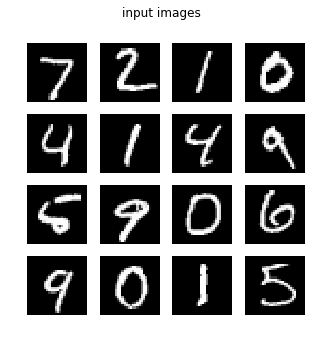

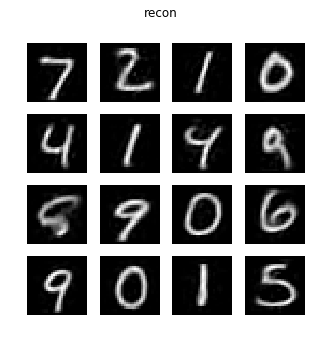

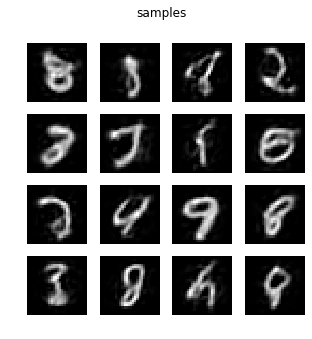

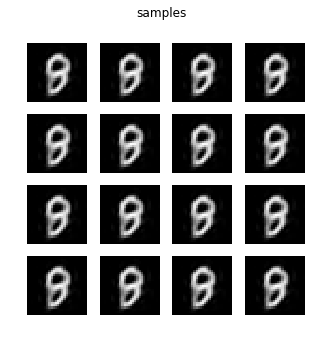

In [28]:
p_samples = sess.run(prior_sample)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('recon')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(rec[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
p_samples = np.zeros_like(p_samples)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})

print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

**Fit NVP to posterior for better samples**

In [0]:
# nvp_loss = []
# ii     = 0
# nepoch = 0
# learning_rate = 1e-3

In [0]:
# #train the nvp
# while nepoch<1000:
#   if (ii+1)*batch_size>len(x_train): 
#     np.random.shuffle(x_train)
#     ii=0
#     nepoch+=1
#     print('starting epoch', nepoch)
#   if nepoch>10:
#     learning_rate=1e-5
#   if nepoch>200:
#     learning_rate=1e-6
#   x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
#   _, ll = sess.run([opt_op_nvp,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
#   nvp_loss+=[ll]
#   if ii%500==0:
#     print(ll)
#   ii+=1

In [0]:
# plt.figure()
# plot(nvp_loss[::],label='nvp loss')
# legend()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:05:08.029361 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


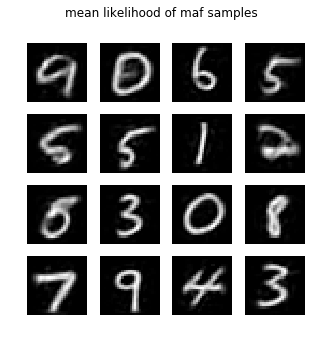

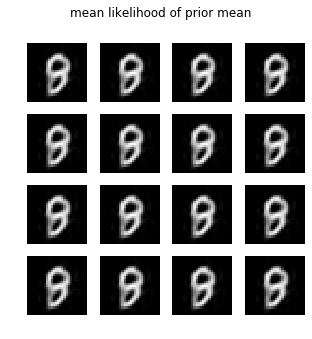

In [29]:
samples1 = sess.run(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])

s = sess.run(sample_mean, feed_dict={prior_samples: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
    
s = sess.run(sample_mean, feed_dict={prior_samples: np.zeros_like(samples1)})

figure(figsize=(5,5))
suptitle('mean likelihood of prior mean')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#nvp_funcs.export(nvp_func_path,sess)


In [13]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':10000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 04:53:53.923635 139941427271552 saver.py:1483] Saver not created because there are no variables in the graph to restore


(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


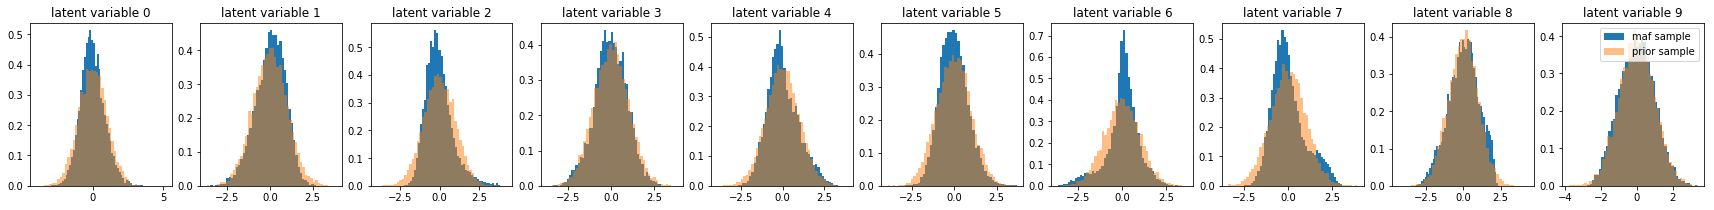

In [14]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

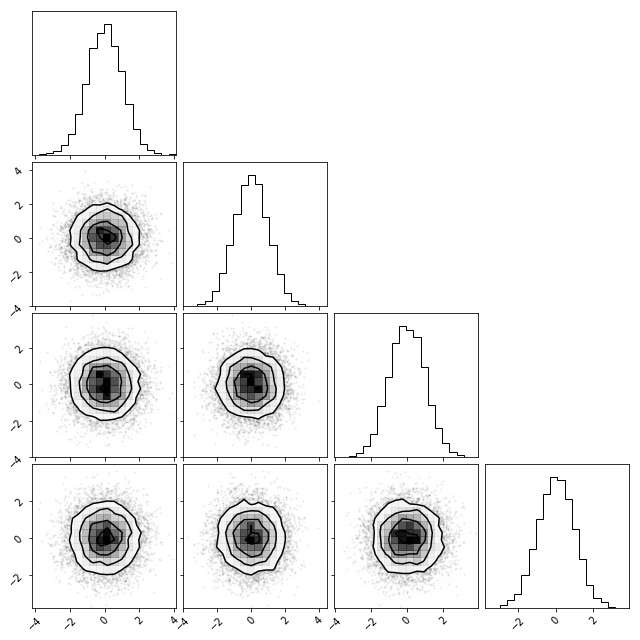

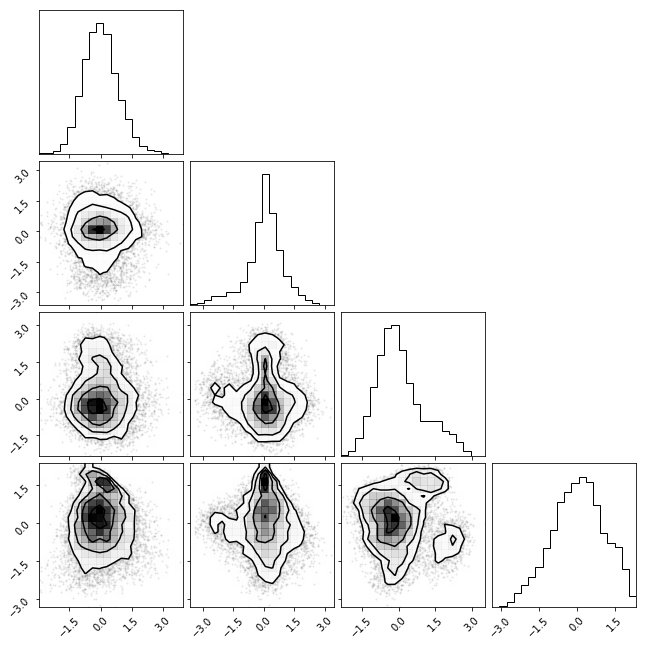

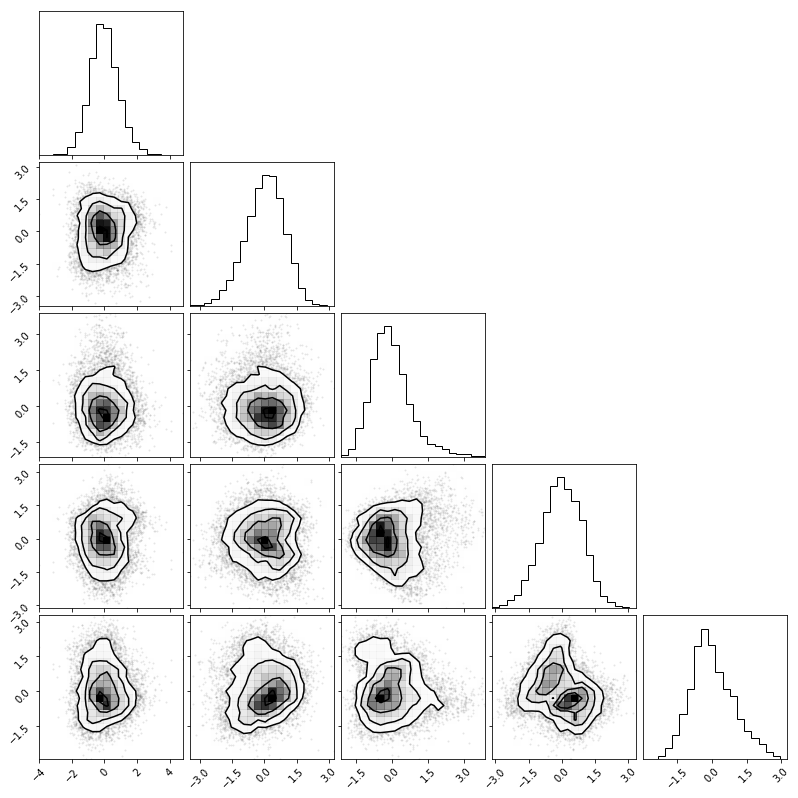

In [150]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])
_ = corner.corner(maf_s[:,0:5])

**Make corrupted data**

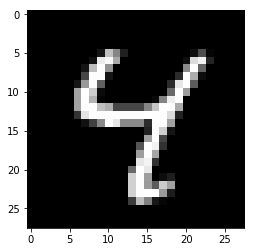

In [30]:

mask = np.ones(IMAGE_SHAPE, dtype=int)
# use also 12:18/12:20 -> 4 
minx = 0
maxx = 0
mask[0:28,minx:maxx]=0.
mask = mask.reshape((28*28))
sigma_new = np.ones(mask.shape)*sigma_n
sigma_new[np.where(mask==0)] = sigma_n*1e4
x_true = x_test[6:6+batch_size2]
masked_data = x_true*[mask]
sigma_new = np.asarray([np.expand_dims(sigma_new,-1)]*batch_size2)

data = np.expand_dims(masked_data,-1)
plt.figure()
_=plt.imshow(x_true.reshape((28,28)),cmap='gray',vmin=0)
x = np.arange(28)
plt.fill_between(x, 0, 27, where=[(x>=minx)*(x<=maxx)][0] ,facecolor='limegreen', alpha=0.5)
plt.show()


**Minimize ELBO for corrupted data and look at samples**

A) mean field

In [0]:
posterior_loss=[]

In [29]:
lrate=1e-5
for ii in range(16000):
  if ii >8000:
    lrate=1e-5
  _, ll = sess.run([opt_op_elbo, elbo],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%1000==0:
    print(ll)

1693.894
1696.0929
1693.028
1695.516
1699.5219
1701.8044
1696.8915
1692.9963
1694.7426
1694.7432
1695.3431
1697.4376
1697.8002
1691.7605
1692.3821
1705.4315


In [33]:
lrate=1e-20
for ii in range(1000):
  if ii >1000:
    lrate=1e-10
  _, ll = sess.run([grad_opt.minimize(elbo,var_list=[mu_elbo,sigma_elbo]), elbo],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%1==0:
    print(ll)

KeyboardInterrupt: ignored

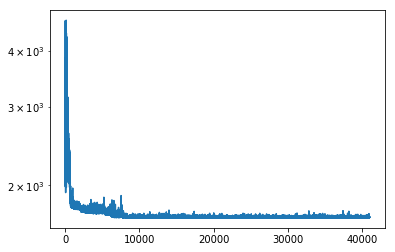

In [31]:
plt.plot(posterior_loss)
yscale('log')

In [37]:
mean    = sess.run(mean_corr_likelihood,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})

VI_mean, VI_cov = sess.run([approx_posterior_elbo.mean(),approx_posterior_elbo.covariance()],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_min_loss     = sess.run(approx_posterior_elbo.log_prob(VI_mean),feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_min_loss = - VI_min_loss
print(VI_mean,VI_min_loss)

[[ 3.8282645  -0.78783435  0.8812547  -0.61627644  0.7542642   1.8521817
  -1.5651649  -3.6245492   2.4686444  -0.2878965 ]] [-19.134296]


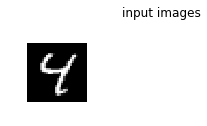

TypeError: ignored

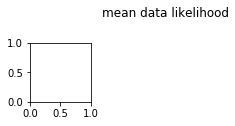

In [33]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'mfVI_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'mfVImasked_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
import pickle
try:
  VI_mean, VI_cov, VI_loss = pickle.load(open(minima_path+'nvp_meanfieldVI_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except: 
  pickle.dump([VI_mean, VI_cov, VI_min_loss],open(minima_path+'nvp_meanfieldVI_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))


B) full rank

In [0]:
posterior_loss=[]
#sess.run([reset_elbo, reset_elbo2],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})

In [93]:
lrate=1e-5
for ii in range(2000):
  _, ll = sess.run([opt_op_elbo_f, elbo_f],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%100==0:
    print(ll)

1721.465
1728.6616
1722.5568
1722.3137
1724.694
1731.5184
1723.983
1724.3993
1721.6703
1721.1686
1721.4432
1720.5579
1722.9354
1724.6426
1719.8433
1722.0986
1720.6879
1725.7019
1734.3884
1724.2145


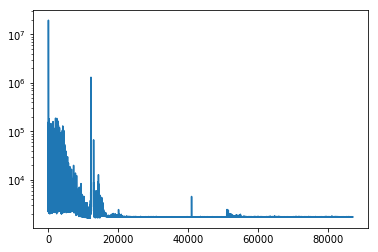

In [91]:
plt.plot(posterior_loss)
yscale('log')

In [92]:
lrate=1e-10
for ii in range(1000):
  if ii >1000:
    lrate=1e-10
  _, ll = sess.run([grad_opt.minimize(elbo_f,var_list=[mu_elbo_f_,sigma_f_elbo]), elbo_f],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%1==0:
    print(ll)

1727.6273
1726.9376
1725.7814
1730.0415
1726.6383
1724.6614
1726.3088
1725.8949
1728.9171
1723.3904


KeyboardInterrupt: ignored

In [94]:
mean   = sess.run(mean_corr_likelihood_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_mean, VI_f_cov = sess.run([approx_posterior_f_elbo.mean(),approx_posterior_f_elbo.covariance()],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_min_loss = sess.run(approx_posterior_f_elbo.log_prob(VI_f_mean),feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_min_loss = -VI_f_min_loss
print(VI_f_mean,VI_f_min_loss)

[[ 4.519319    0.13138086 -2.3007474  -0.5305184   1.924843    1.4704282
   0.78605163 -3.5949123   2.169984    0.6294842 ]] [-15.843215]


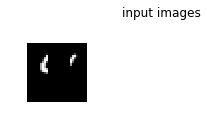

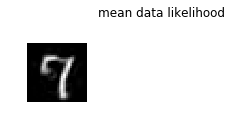

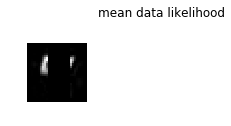

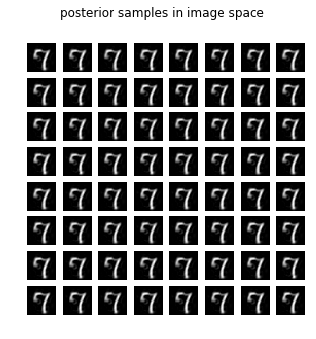

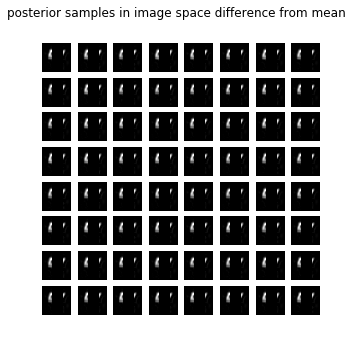

In [95]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'frfVI_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')

plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'frfVI_samplesmasked_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
try:
  VI_f_mean, VI_f_cov,VI_f_min_loss = pickle.load(open(minima_path+'nvp_fullrankVI_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  
  pickle.dump([VI_f_mean, VI_f_cov,VI_f_min_loss],open(minima_path+'nvp_fullrankVI_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))

**find minima with nvp**

0
2309.1082
1646.4199
1646.9393
1646.5632
1646.4055
1647.0195
1646.121
1650.221
1646.7992
1646.4067
switching to lr 0.01
1647.2695
1645.9263
1645.9314
switching to lr 0.001
1645.9119
1645.8856
1645.8928
switching to lr 0.0001
0 1645.8838
1 1645.8795
2 1645.8787
3 1645.8794
4 1645.878
5 1645.8793
6 1645.8779
7 1645.8777
8 1645.8776
9 1645.8777
10 1645.8774
11 1645.8773
[[1.7321433e+00 1.8907057e+00 5.0032492e+00 7.1882553e+00 1.9013313e+01
  4.1133553e+01 1.6725391e+02 3.4722226e+02 1.5622056e+03 1.1923991e+04]]
1
2145.2422
1676.5394
1670.4286
1679.4176
1664.2582
1675.5471
1673.5388
1673.836
1673.7587
1674.4834
switching to lr 0.01
1673.8519
1673.4182
1673.4247
switching to lr 0.001
1673.4453
1673.3582
1673.3632
switching to lr 0.0001
0 1673.3492
1 1673.393
2 1673.3872
3 1673.3611
4 1673.3905
5 1673.3997
6 1673.3717
7 1673.3779
8 1673.3948
9 1673.3655
10 1673.3778
11 1673.4052
[[4.7893482e-01 1.2661718e+00 2.8905094e+00 6.8449092e+00 1.5476935e+01
  1.6332191e+02 3.2118692e+02 8.7108215

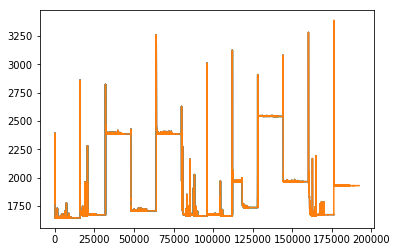

In [108]:
posterior_corr_loss = []
l_minima            = []
map_minima          = []
pos_def             = []
for ii in range(12):
  print(ii)
  if ii ==1:
    ini = np.zeros((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))+1e-8
  elif ii==0:
    #starting from truth
    ini = sess.run(mu_x,feed_dict={x_ul: np.expand_dims(x_true,-1)})
  else:
    ini = np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, sigma_corr:sigma_new})
  lrate=1e-1
  for jj in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  lrate=1e-2
  print('switching to lr', lrate)
  for jj in range(3000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for jj in range(3000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  lrate=1e-4
  print('switching to lr', lrate)
  for jj in range(20):
    _, ll = sess.run([grad_opt.minimize(loss_MAP, var_list=[MAP]),loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1==0:
      print(jj, ll)
    if jj>10:
      # inspect eigenvalues of hessian
      ev= sess.run(eig1,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})
      print(ev)
      if np.all(ev>0.):
        if ii is not 0:
          pos_def+=[ii]
        break
  plot(posterior_corr_loss,label='data_loss')
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new})]

[1, 10, 11]


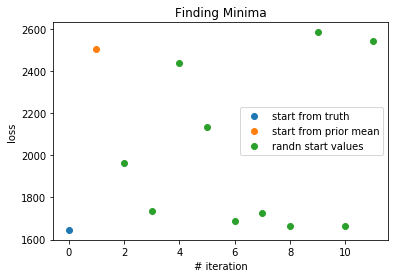

In [112]:
print(pos_def)
l_minima_pos_def = l_minima[pos_def]
map_minima_pos_def = map_minima[pos_def]
plt.figure()
plt.title('Finding Minima')
plt.plot(0,l_minima[0],ls='',marker='o',label='start from truth')
plt.plot(1,l_minima[1],ls='',marker='o',label='start from prior mean')
plt.plot(np.arange(len(l_minima)-2)+2,l_minima[2::],ls='',marker='o', label='randn start values')
plt.xlabel('# iteration')
plt.ylabel('loss')
plt.legend()
plt.savefig(plot_path+'minimzation_results_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
import pickle
try:
  #l_minima,map_minima,l_minima_pos_def,map_minima_pos_def = pickle.load(open(minima_path+'nvp_minima_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
  l_minima,map_minima = pickle.load(open(minima_path+'nvp_minima_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([l_minima,map_minima,l_minima_pos_def,map_minima_pos_def],open(minima_path+'nvp_minima_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))
  
map_minima = np.asarray(map_minima)
l_minima   = np.asarray(l_minima)

In [63]:
print(map_minima[0])
print(VI_f_mean)
print(VI_mean)

[[[ 2.5158231   0.54948133 -1.4606208   0.6180156   0.6142714
    0.8875758  -0.2298886  -3.6828494   1.2015607  -0.5029857 ]]]
[[ 3.9221215  -0.9864003  -1.6850537  -1.1478671   0.85993564  2.2493565
  -0.57348365 -3.3277936   2.2404249   0.93711597]]
[[ 4.72725     0.21510254 -2.38855    -1.1522334   2.0106003   1.4222734
   0.75022495 -3.7624278   2.1510346   0.5902636 ]]


**Sample posterior of (un)corrupted data**

In [0]:
samples_mcmc, mcmc_stats_ = sess.run([mcmc_samples,mcmc_stats],feed_dict={x_corr: np.expand_dims(masked_data,-1),sigma_corr:sigma_new, nvp_prior:True})

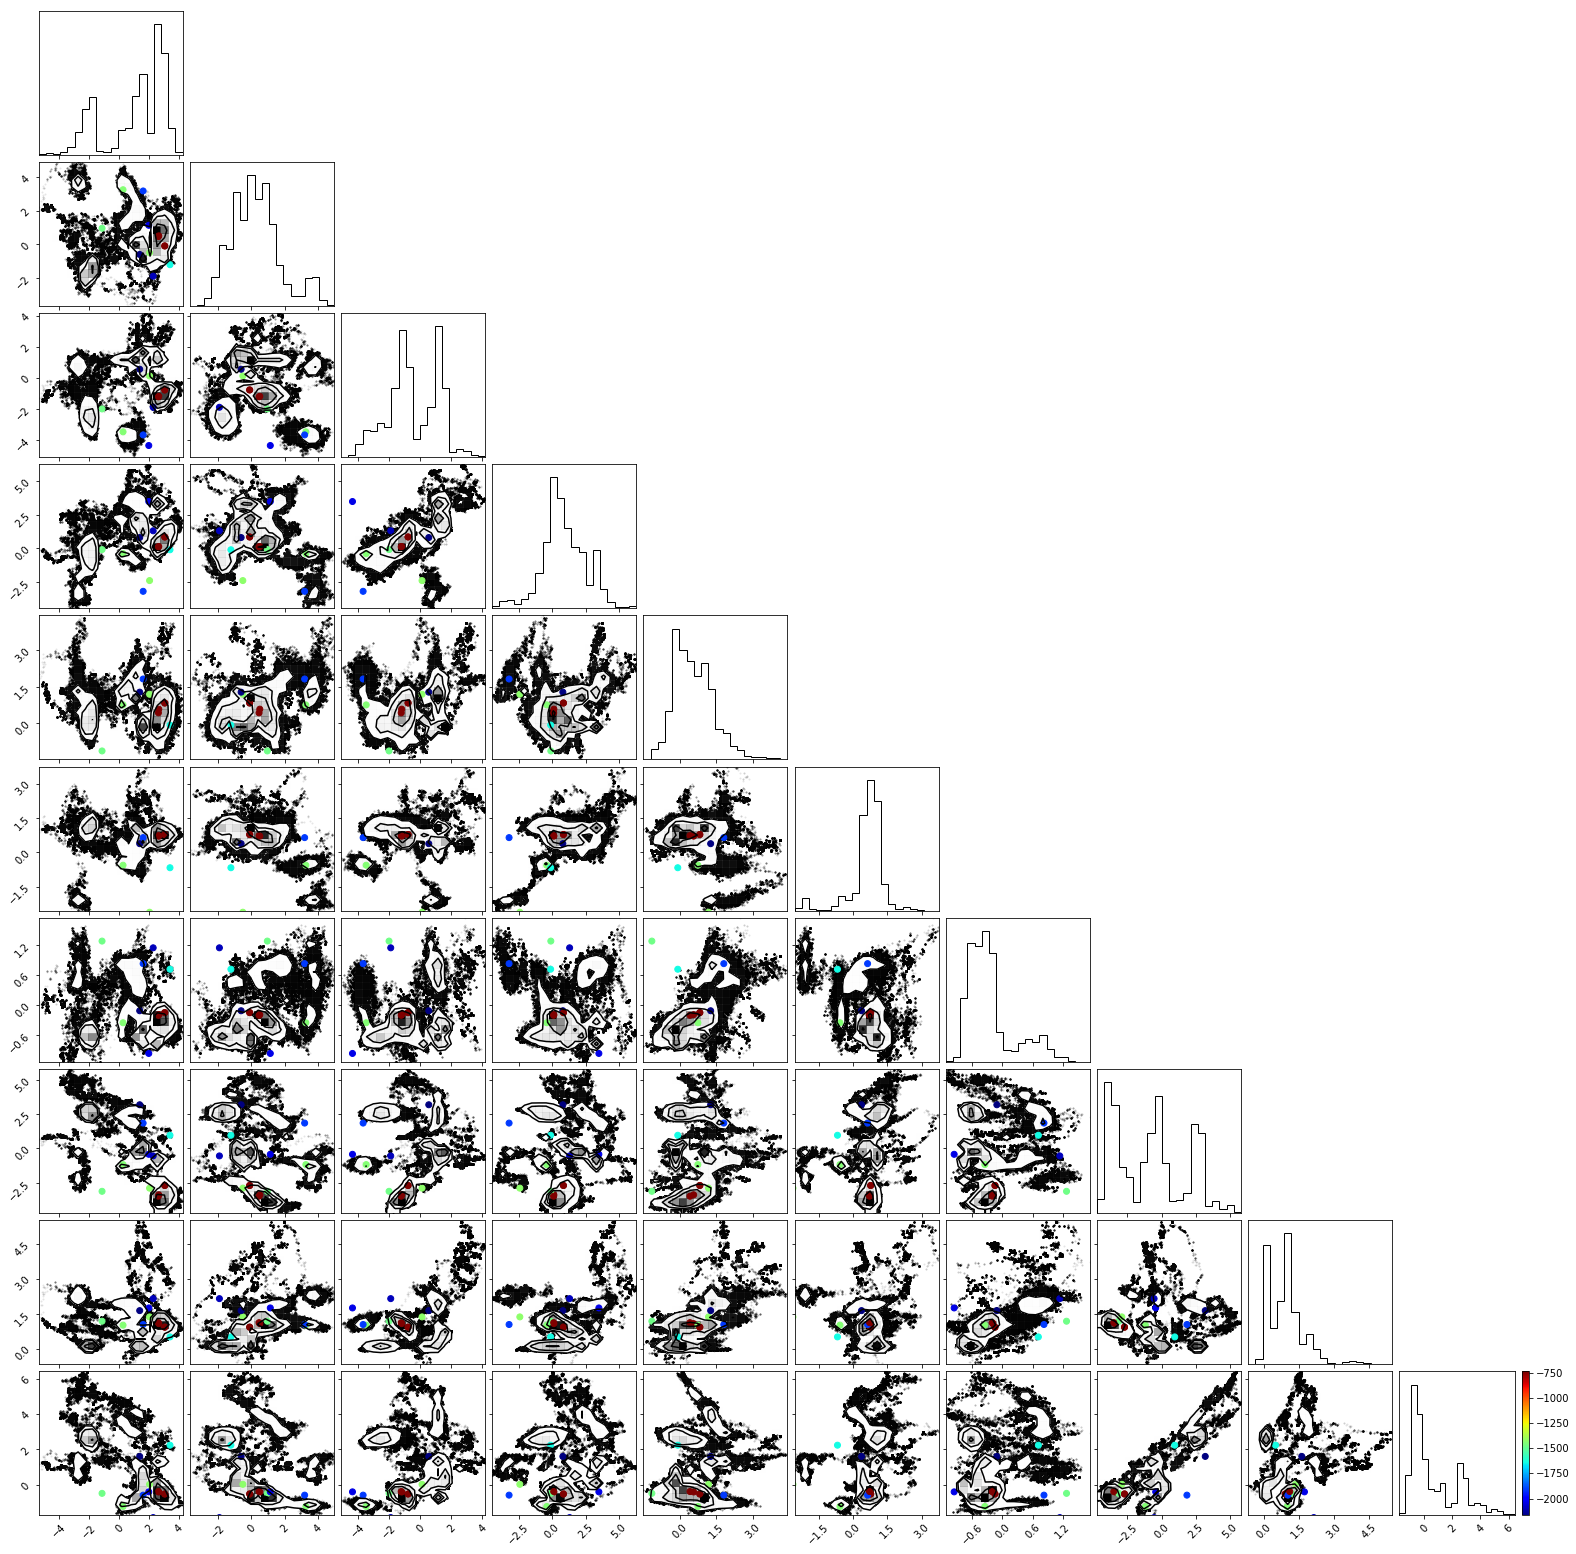

In [123]:
figure = corner.corner(np.reshape(samples_mcmc,[-1,hidden_size]))
axes   = np.array(figure.axes).reshape((hidden_size, hidden_size))

# # # # Loop over the histograms
for yi in range(hidden_size):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax_=ax.scatter(map_minima[:,0,0,xi], map_minima[:,0,0,yi], c=-l_minima, cmap='jet')
        #for i, txt in enumerate(l_minima_old):
        #  ax.annotate('%d'%txt, (map_minima_old[i,0,0,xi], map_minima_old[i,0,0,yi]),color='red', fontsize=10)
plt.colorbar(ax_)

In [0]:
#corrupted data
samples_, kernel_results_ = sess.run([hmc_samples, hmc_kernel_results],feed_dict={x_corr: np.expand_dims(masked_data,-1),sigma_corr:sigma_new, nvp_prior:True})

In [96]:
samples_.shape
print(max(kernel_results_.accepted_results.target_log_prob.flatten()),-min(l_minima))

-987.4353 -734.68427


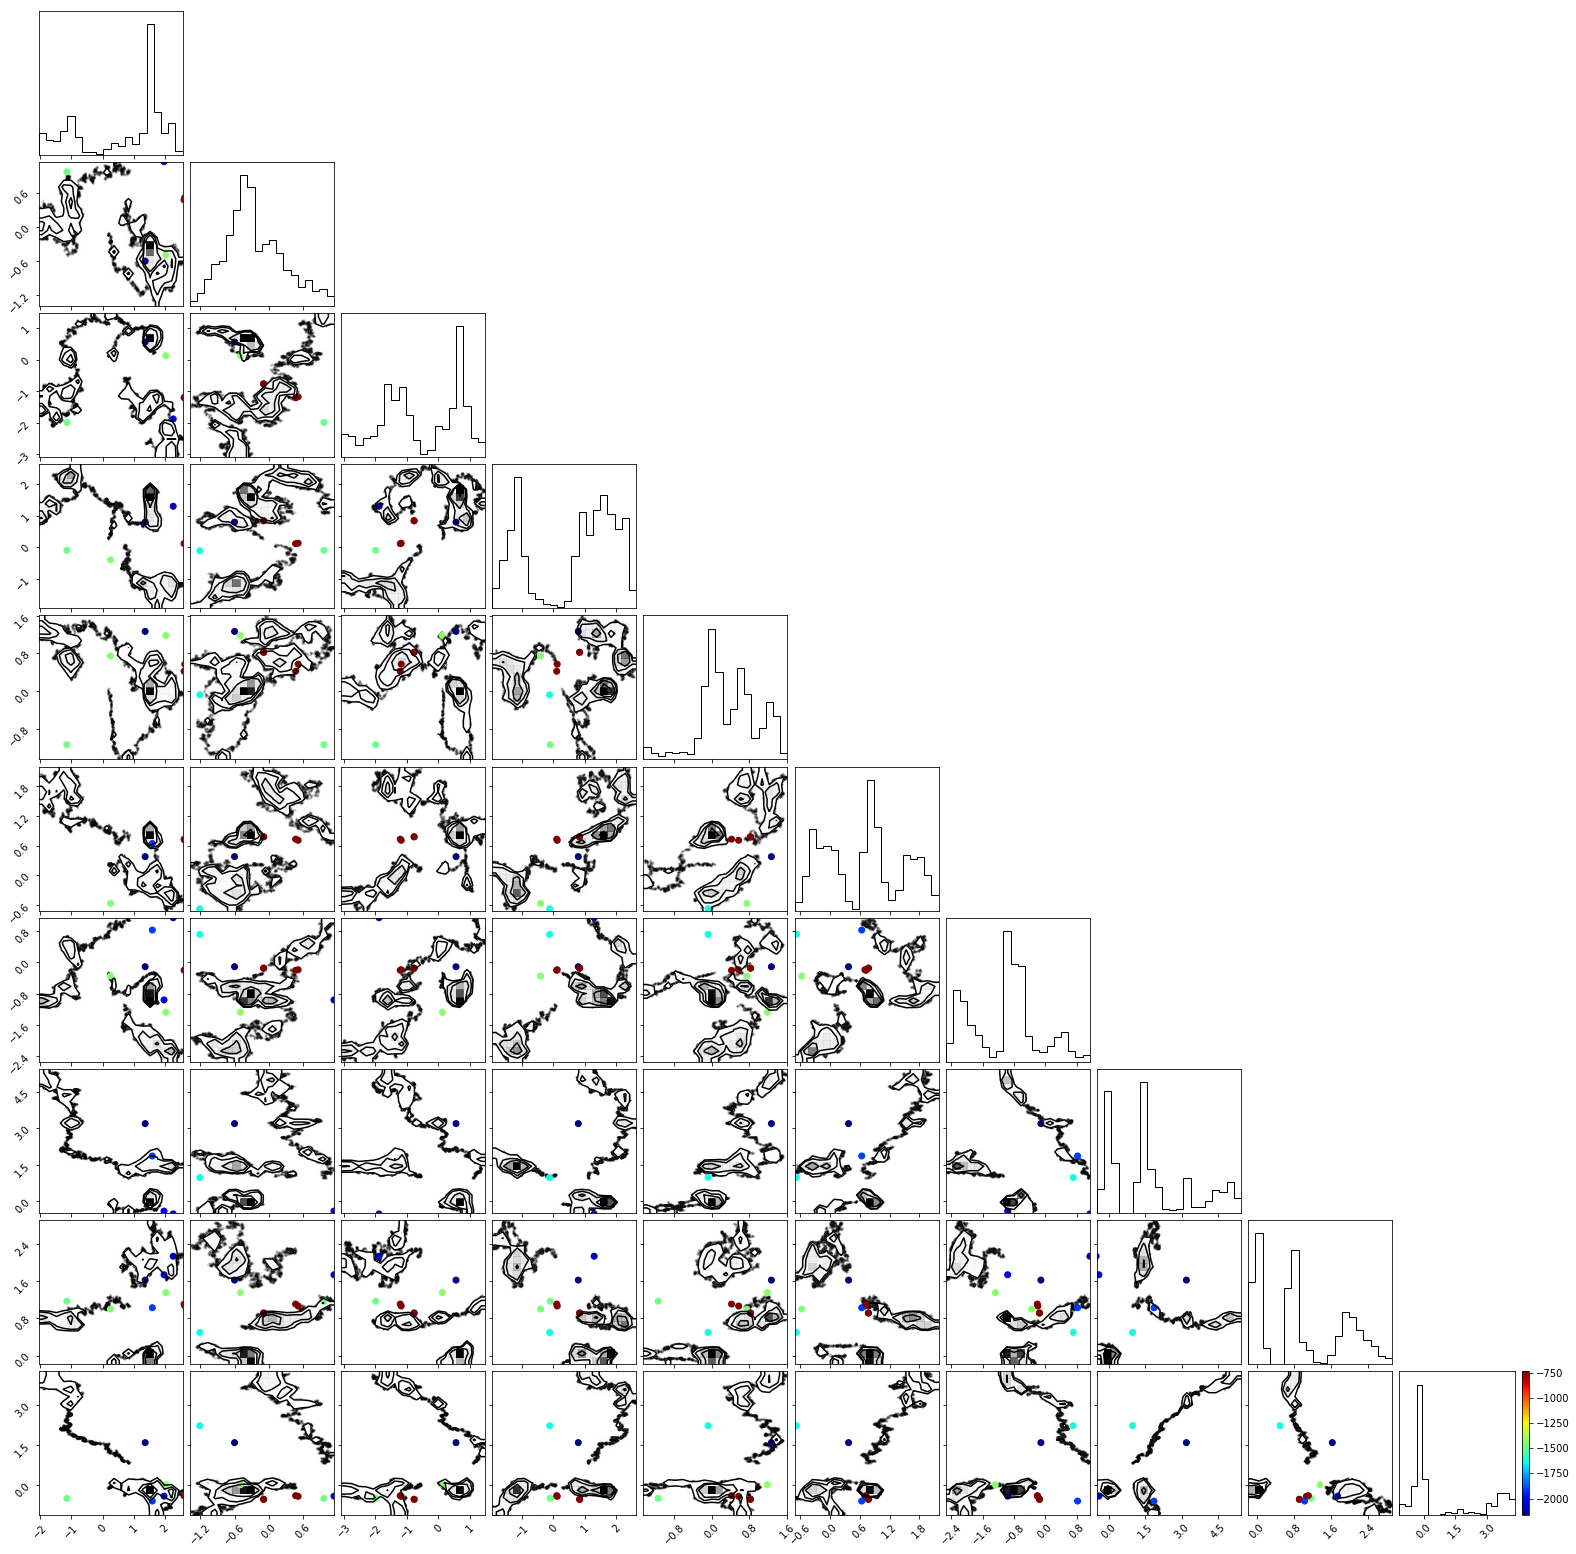

In [111]:
order = np.argsort(l_minima)

figure = corner.corner(np.reshape(samples_,[-1,hidden_size]))#,truths = map_minima_old[order][0,0,0,:])
axes   = np.array(figure.axes).reshape((hidden_size, hidden_size))

# # # # Loop over the histograms
for yi in range(hidden_size):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax_=ax.scatter(map_minima[:,0,0,xi], map_minima[:,0,0,yi], c=-l_minima, cmap='jet')
        #for i, txt in enumerate(l_minima_old):
        #  ax.annotate('%d'%txt, (map_minima_old[i,0,0,xi], map_minima_old[i,0,0,yi]),color='red', fontsize=10)
plt.colorbar(ax_)

mean:0.1693  stddev:0.9419  acceptance:0.6615


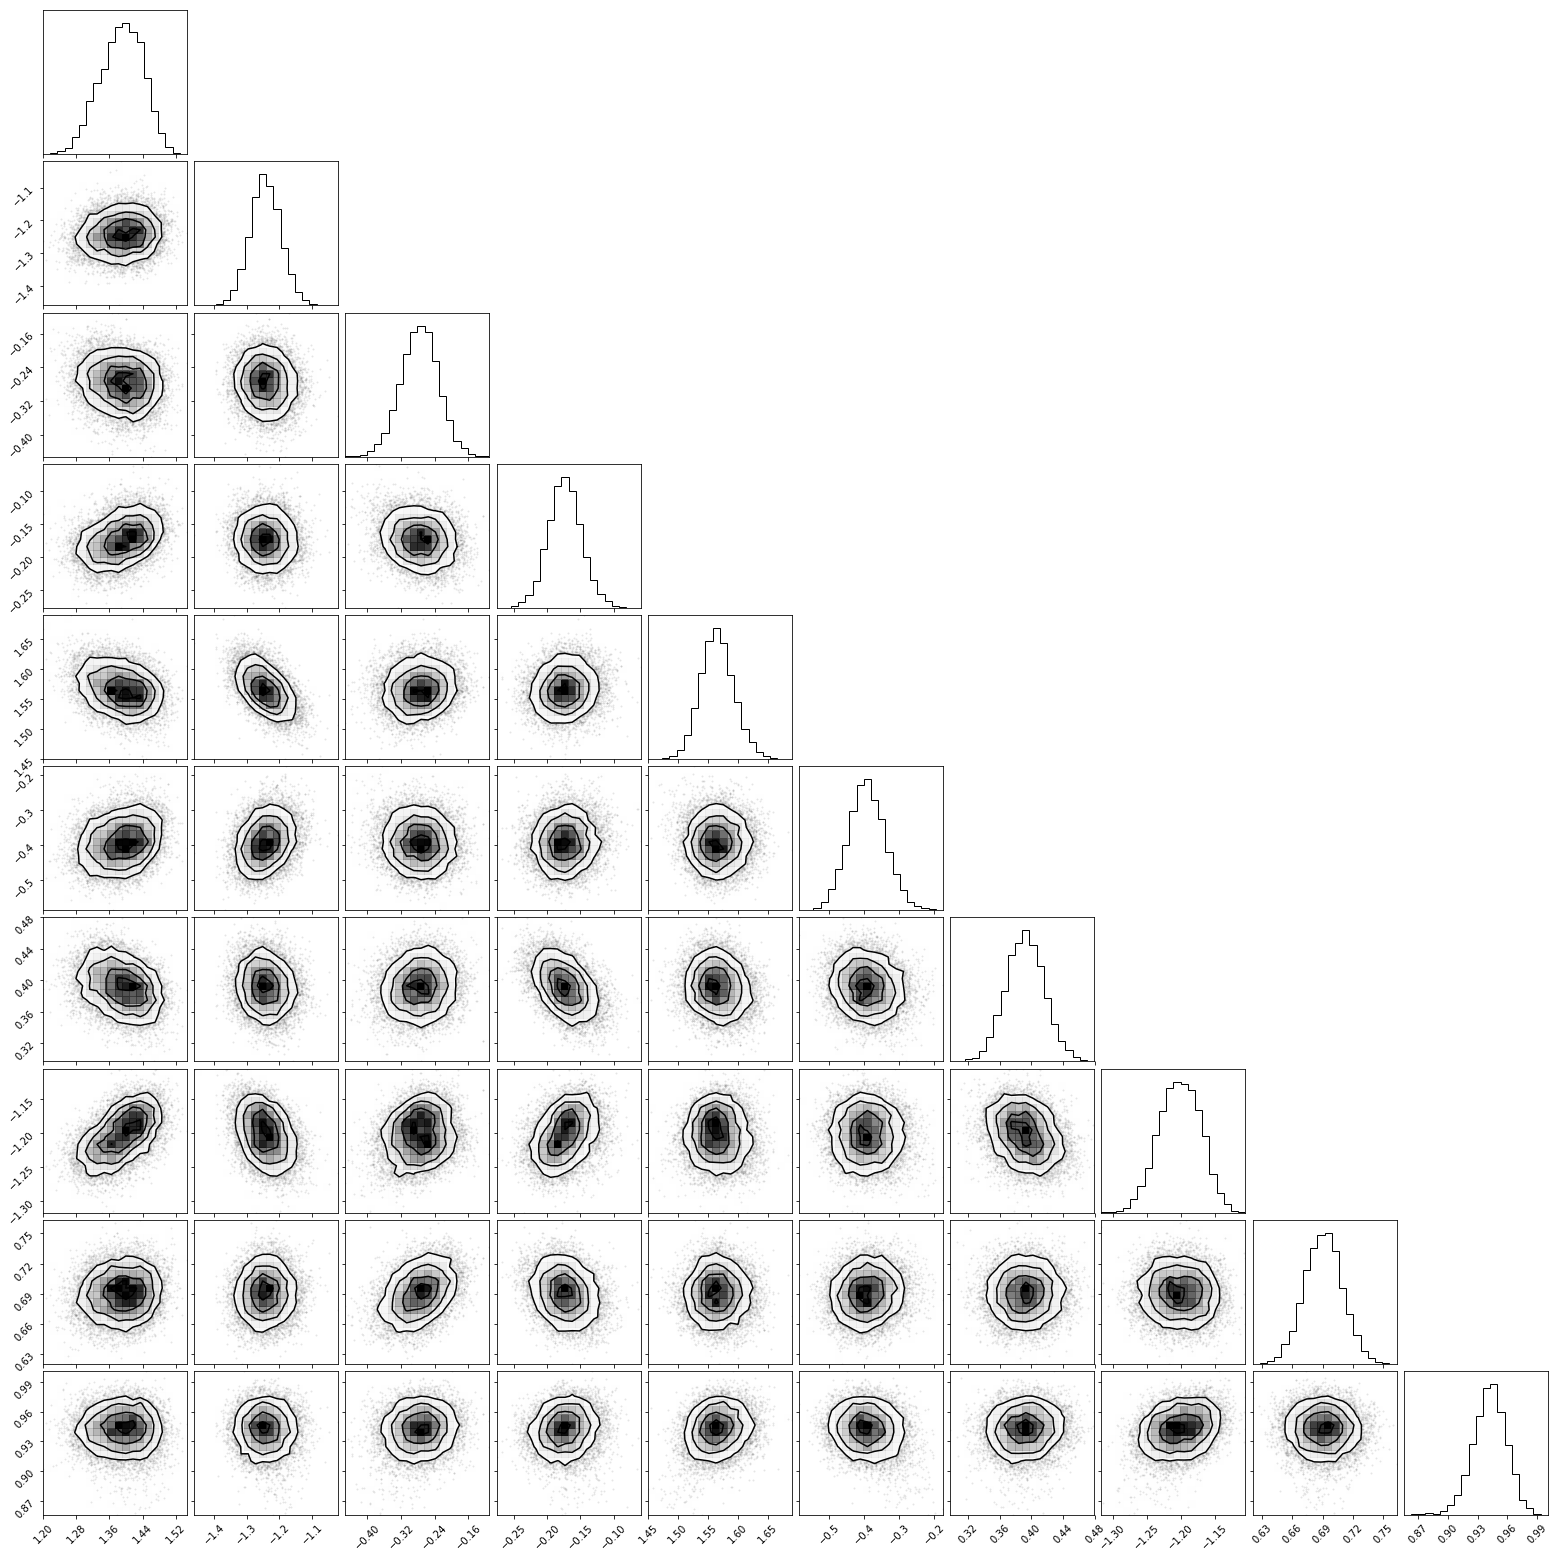

In [16]:
#uncorrupted data
samples_, kernel_results_ = sess.run([samples, kernel_results],feed_dict={x_corr: np.expand_dims(x_true,-1)})
_ = corner.corner(samples_[:,0,:])

**get covariances around minima**

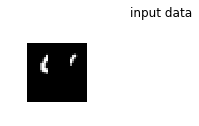

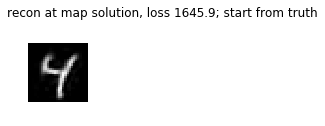

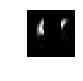

eigenvalues before and after inverse, approx hessian
[array([[9.9577272e-01, 9.9937135e-01, 9.9987793e-01, 9.9992168e-01,
        9.9999666e-01, 1.0000813e+00, 1.0002594e+00, 1.0016011e+00,
        1.0070823e+00, 3.0301384e+05]], dtype=float32), array([[3.30017885e-06, 9.97772630e-01, 9.99260836e-01, 9.99840149e-01,
        9.99942570e-01, 9.99981779e-01, 1.00005052e+00, 1.00009295e+00,
        1.00108693e+00, 1.00220726e+00]])]


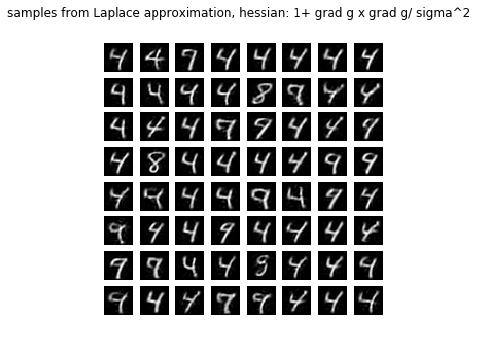

covariances
(1, 10, 10)


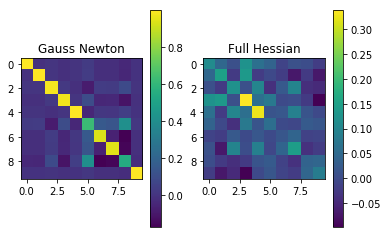

hessians
(1, 10, 10)


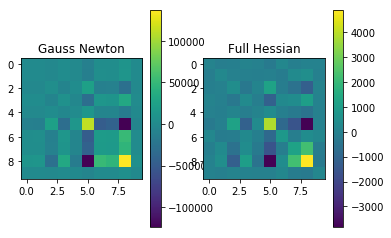

eigenvalues before and after inverse, full hessian
[array([[1.8560488e+00, 2.3197222e+00, 4.7222548e+00, 7.6571178e+00,
        1.8438332e+01, 4.2553421e+01, 1.3792422e+02, 3.9020831e+02,
        1.5675625e+03, 9.9756973e+03]], dtype=float32), array([[1.00243590e-04, 6.37933289e-04, 2.56273336e-03, 7.25036342e-03,
        2.34999773e-02, 5.42346485e-02, 1.30603838e-01, 2.11750329e-01,
        4.31102389e-01, 5.38756413e-01]])]
1


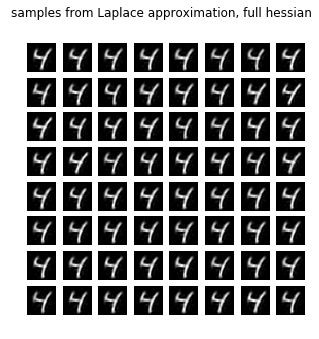

diagonal approx


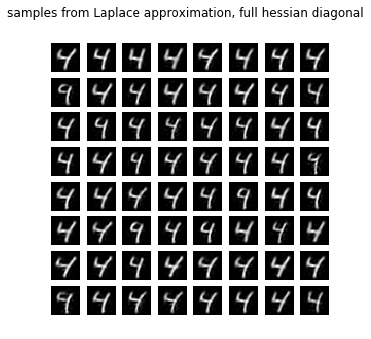

hessian successful 0


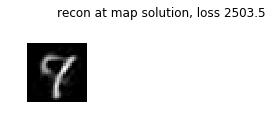

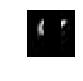

eigenvalues before and after inverse, approx hessian
[array([[9.9356794e-01, 9.9921083e-01, 9.9976540e-01, 9.9995953e-01,
        9.9999493e-01, 1.0000442e+00, 1.0001516e+00, 1.0003378e+00,
        1.0012482e+00, 7.9969961e+04]], dtype=float32), array([[1.25046960e-05, 9.98981099e-01, 9.99732132e-01, 9.99802343e-01,
        9.99923619e-01, 9.99981623e-01, 1.00000177e+00, 1.00010412e+00,
        1.00022302e+00, 1.00104600e+00]])]


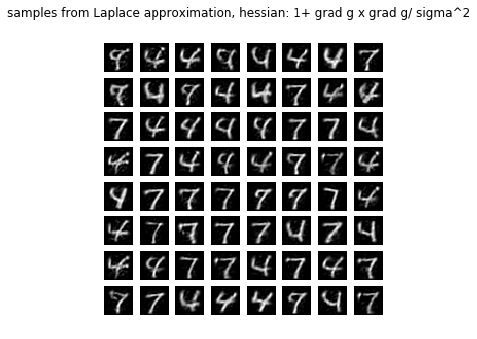

covariances
(1, 10, 10)


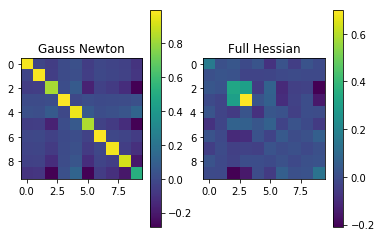

hessians
(1, 10, 10)


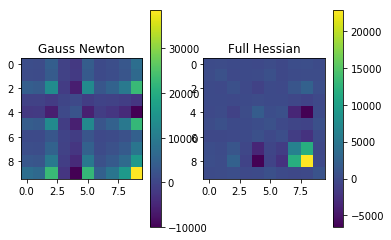

eigenvalues before and after inverse, full hessian
[array([[-7.76932192e+00,  1.02282405e+00,  3.83857441e+00,
         4.44300890e+00,  1.63329315e+01,  1.22137085e+02,
         2.87148315e+02,  1.05949475e+03,  1.92751318e+03,
         3.14800430e+04]], dtype=float32), array([[-1.28716869e-01,  3.17661616e-05,  5.18803607e-04,
         9.43846035e-04,  3.48252279e-03,  8.18749275e-03,
         6.12255320e-02,  2.25083693e-01,  2.60570354e-01,
         9.77802442e-01]])]
1
full hessian fails


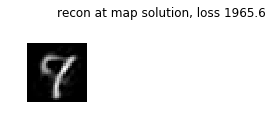

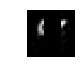

eigenvalues before and after inverse, approx hessian
[array([[9.9945736e-01, 9.9955469e-01, 9.9987286e-01, 9.9995154e-01,
        1.0000135e+00, 1.0001018e+00, 1.0001601e+00, 1.0005926e+00,
        1.0129130e+00, 8.0088383e+04]], dtype=float32), array([[1.24862053e-05, 9.99378230e-01, 9.99801590e-01, 9.99911383e-01,
        9.99957635e-01, 9.99980798e-01, 1.00000526e+00, 1.00002857e+00,
        1.00029377e+00, 1.00103928e+00]])]


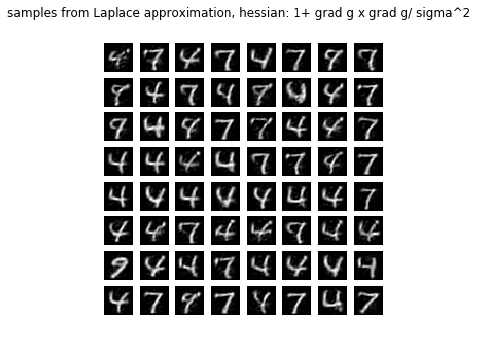

covariances
(1, 10, 10)


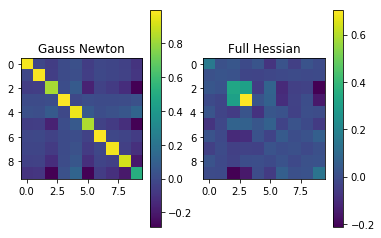

hessians
(1, 10, 10)


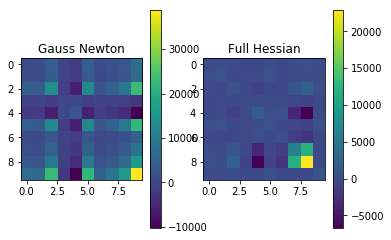

eigenvalues before and after inverse, full hessian
[array([[-7.9192123e+00,  1.0096298e+00,  3.8526518e+00,  4.5139751e+00,
         1.6408550e+01,  1.2265179e+02,  2.8771201e+02,  1.0668864e+03,
         1.9298850e+03,  3.1458613e+04]], dtype=float32), array([[-1.26269865e-01,  3.17877845e-05,  5.18165588e-04,
         9.37306471e-04,  3.47569146e-03,  8.15316645e-03,
         6.09466400e-02,  2.21526407e-01,  2.59560572e-01,
         9.90508446e-01]])]
1
full hessian fails


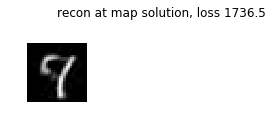

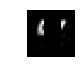

eigenvalues before and after inverse, approx hessian
[array([[9.9908209e-01, 9.9982125e-01, 9.9986780e-01, 9.9997383e-01,
        9.9999917e-01, 1.0000139e+00, 1.0000689e+00, 1.0001923e+00,
        1.0038854e+00, 3.3919074e+04]], dtype=float32), array([[2.94819359e-05, 9.99809073e-01, 9.99911012e-01, 9.99959697e-01,
        9.99996159e-01, 9.99999863e-01, 1.00000135e+00, 1.00005588e+00,
        1.00011569e+00, 1.00028496e+00]])]


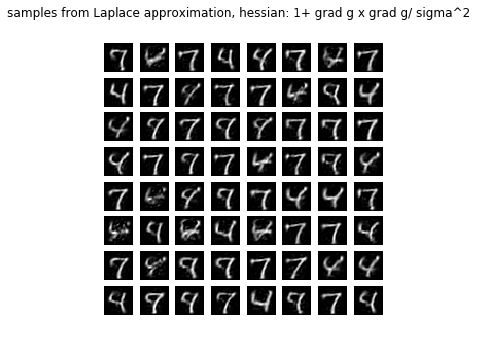

covariances
(1, 10, 10)


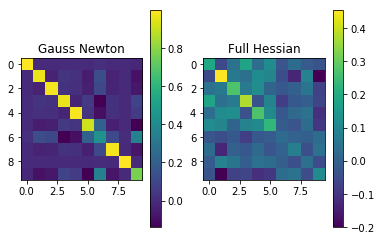

hessians
(1, 10, 10)


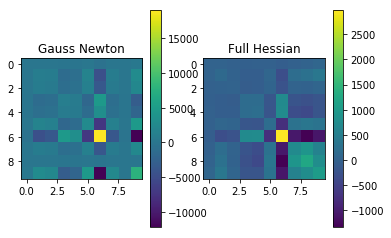

eigenvalues before and after inverse, full hessian
[array([[1.2477933e+00, 1.8940724e+00, 2.9745884e+00, 3.9992294e+00,
        1.1040376e+01, 2.7062407e+01, 4.4182022e+01, 4.7533136e+02,
        8.8520160e+02, 5.3621055e+03]], dtype=float32), array([[1.86493849e-04, 1.12968635e-03, 2.10379334e-03, 2.26336094e-02,
        3.69516159e-02, 9.05781198e-02, 2.50051321e-01, 3.36181909e-01,
        5.27933830e-01, 8.01338026e-01]])]
1


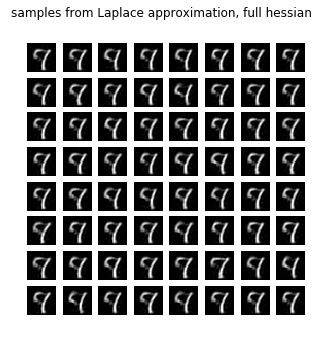

diagonal approx


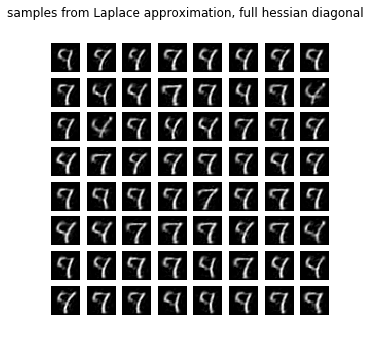

hessian successful 3


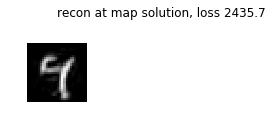

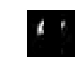

eigenvalues before and after inverse, approx hessian
[array([[9.8950791e-01, 9.9948514e-01, 9.9993151e-01, 9.9999708e-01,
        1.0000032e+00, 1.0000296e+00, 1.0001254e+00, 1.0006980e+00,
        1.0024482e+00, 5.8524129e+04]], dtype=float32), array([[1.70869684e-05, 9.99061273e-01, 9.99823677e-01, 9.99959873e-01,
        9.99997137e-01, 1.00000364e+00, 1.00002633e+00, 1.00003729e+00,
        1.00037727e+00, 1.00118865e+00]])]


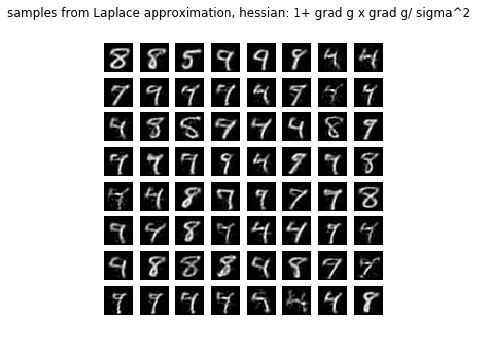

covariances
(1, 10, 10)


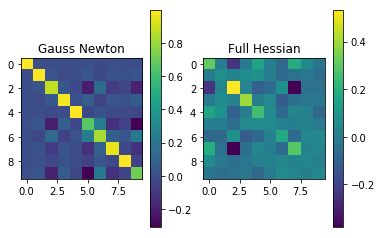

hessians
(1, 10, 10)


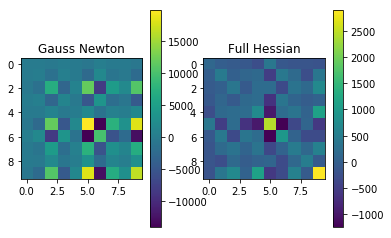

eigenvalues before and after inverse, full hessian
[array([[9.8292810e-01, 1.9661071e+00, 3.0109146e+00, 6.0037160e+00,
        7.8545866e+00, 8.2980949e+01, 4.8398541e+02, 9.0864160e+02,
        3.1278672e+03, 4.5240347e+03]], dtype=float32), array([[2.21041628e-04, 3.19706633e-04, 1.10054379e-03, 2.06617945e-03,
        1.20510090e-02, 1.27315319e-01, 1.66559411e-01, 3.32134624e-01,
        5.08593676e-01, 1.01731541e+00]])]
1


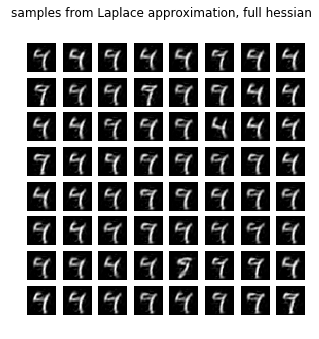

diagonal approx


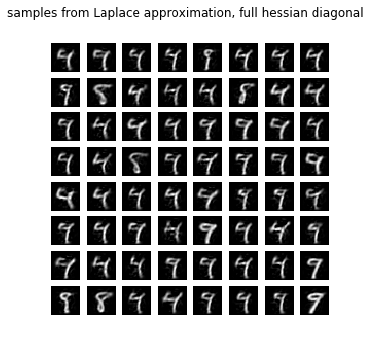

hessian successful 4


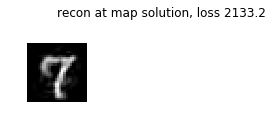

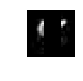

eigenvalues before and after inverse, approx hessian
[array([[9.9945444e-01, 9.9997288e-01, 9.9999183e-01, 9.9999774e-01,
        1.0000002e+00, 1.0000007e+00, 1.0000174e+00, 1.0007393e+00,
        1.0032053e+00, 5.3353312e+04]], dtype=float32), array([[1.87429782e-05, 9.99558558e-01, 9.99973050e-01, 9.99997582e-01,
        9.99999856e-01, 1.00000020e+00, 1.00000408e+00, 1.00002582e+00,
        1.00007243e+00, 1.00066876e+00]])]


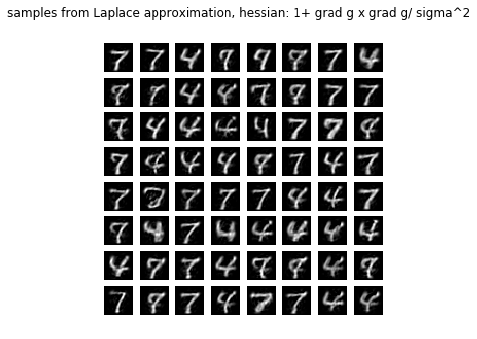

covariances
(1, 10, 10)


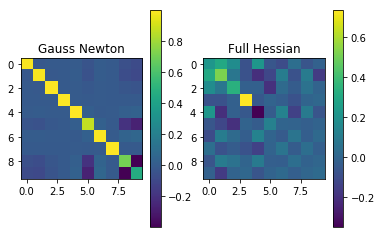

hessians
(1, 10, 10)


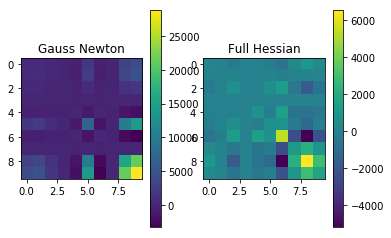

eigenvalues before and after inverse, full hessian
[array([[-1.4464734e+00,  1.0916008e+00,  1.4347966e+00,  2.4861407e+00,
         5.1789112e+00,  6.2625401e+01,  8.2815811e+01,  8.8447302e+02,
         1.7600173e+03,  1.4337635e+04]], dtype=float32), array([[-6.91296450e-01,  6.97465070e-05,  5.68176610e-04,
         1.13061743e-03,  1.20749794e-02,  1.59679041e-02,
         1.93081289e-01,  4.02231263e-01,  6.96964179e-01,
         9.16066470e-01]])]
1
full hessian fails


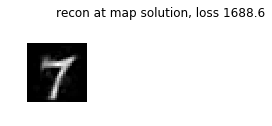

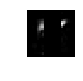

eigenvalues before and after inverse, approx hessian
[array([[9.9951530e-01, 9.9991620e-01, 9.9998367e-01, 9.9999791e-01,
        1.0000015e+00, 1.0000520e+00, 1.0000972e+00, 1.0001132e+00,
        1.0021169e+00, 1.9449033e+04]], dtype=float32), array([[5.14164419e-05, 9.99803813e-01, 9.99886039e-01, 9.99946885e-01,
        9.99976886e-01, 9.99998757e-01, 1.00000237e+00, 1.00000700e+00,
        1.00003312e+00, 1.00023293e+00]])]


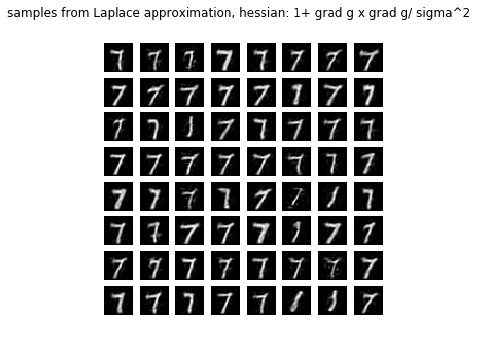

covariances
(1, 10, 10)


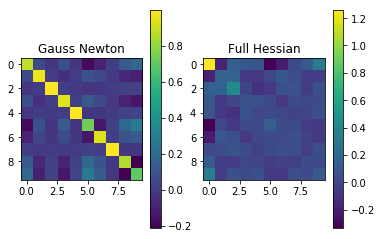

hessians
(1, 10, 10)


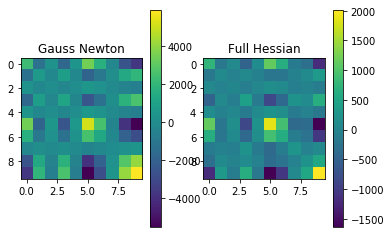

eigenvalues before and after inverse, full hessian
[array([[-8.4790850e+00,  6.5124464e-01,  1.6979374e+00,  5.4818406e+00,
         1.1132546e+01,  5.6507629e+01,  8.1274261e+01,  1.4976196e+02,
         6.8392297e+02,  5.4105752e+03]], dtype=float32), array([[-1.17937291e-01,  1.84823237e-04,  1.46215265e-03,
         6.67725534e-03,  1.23040073e-02,  1.76967433e-02,
         8.98269955e-02,  1.82416434e-01,  5.88943697e-01,
         1.53602803e+00]])]
1
full hessian fails


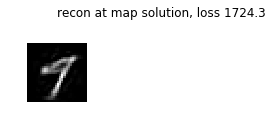

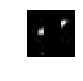

eigenvalues before and after inverse, approx hessian
[array([[9.9760532e-01, 9.9974543e-01, 9.9999797e-01, 9.9999982e-01,
        1.0000001e+00, 1.0000004e+00, 1.0000197e+00, 1.0000554e+00,
        1.0037128e+00, 3.0034402e+04]], dtype=float32), array([[3.32951549e-05, 9.99510452e-01, 9.99934791e-01, 9.99983693e-01,
        9.99999598e-01, 9.99999949e-01, 1.00000005e+00, 1.00000058e+00,
        1.00008793e+00, 1.00021192e+00]])]


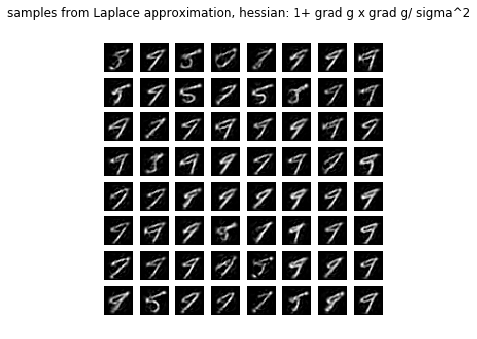

covariances
(1, 10, 10)


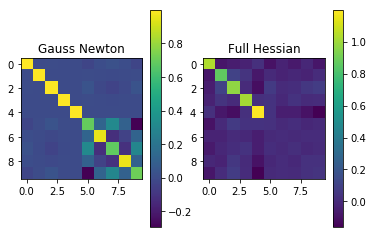

hessians
(1, 10, 10)


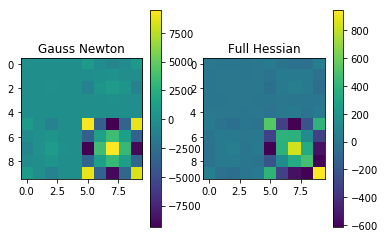

eigenvalues before and after inverse, full hessian
[array([[7.4797499e-01, 9.0507680e-01, 1.0092762e+00, 1.0752864e+00,
        1.2530400e+00, 2.3024504e+01, 6.9813385e+01, 1.9030978e+02,
        6.0551385e+02, 2.3219727e+03]], dtype=float32), array([[4.30668234e-04, 1.65149004e-03, 5.25459107e-03, 1.43238817e-02,
        4.34320237e-02, 7.98059276e-01, 9.29984440e-01, 9.90809120e-01,
        1.10487925e+00, 1.33693618e+00]])]
1


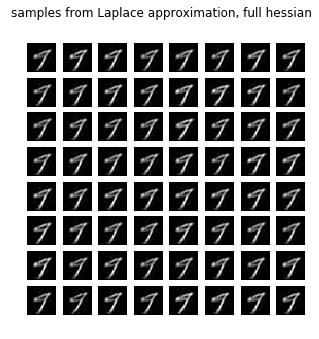

diagonal approx


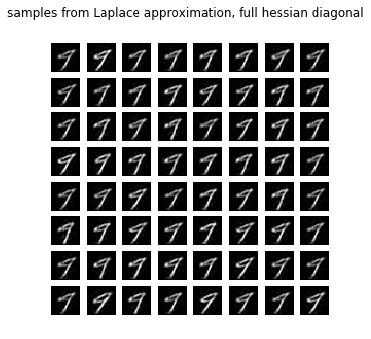

hessian successful 7


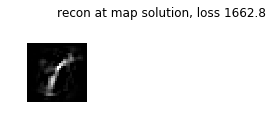

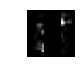

eigenvalues before and after inverse, approx hessian
[array([[9.5274258e-01, 9.9891114e-01, 9.9982405e-01, 9.9992633e-01,
        9.9999046e-01, 1.0001179e+00, 1.0006111e+00, 1.0038898e+00,
        1.0046633e+00, 3.4889388e+05]], dtype=float32), array([[2.86620060e-06, 9.96059916e-01, 9.98958198e-01, 9.99569304e-01,
        9.99975258e-01, 1.00001217e+00, 1.00006543e+00, 1.00023218e+00,
        1.00087224e+00, 1.00098171e+00]])]


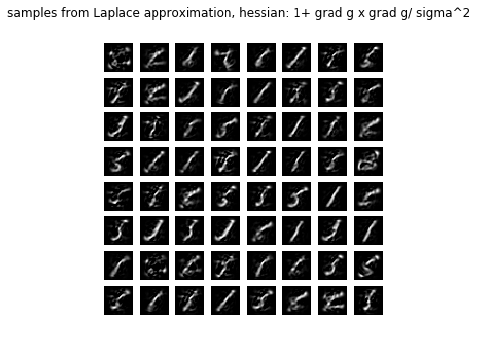

covariances
(1, 10, 10)


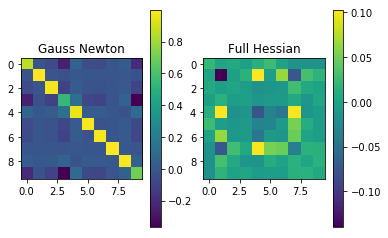

hessians
(1, 10, 10)


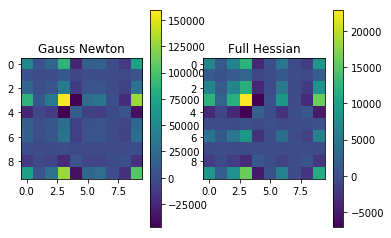

eigenvalues before and after inverse, full hessian
[array([[-6.1749367e+01, -1.1382850e+01, -3.1224148e+00,  1.5627345e+01,
         2.0517834e+01,  4.6411766e+01,  4.9831062e+01,  1.4100038e+02,
         9.6759009e+02,  5.3341324e+04]], dtype=float32), array([[-3.20227255e-01, -8.78498435e-02, -1.61944953e-02,
         1.87471930e-05,  1.03349556e-03,  7.09220836e-03,
         2.00673095e-02,  2.15465630e-02,  4.87419498e-02,
         6.39968209e-02]])]
1
full hessian fails


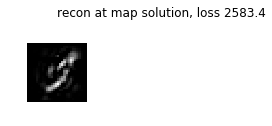

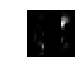

eigenvalues before and after inverse, approx hessian
[array([[9.9828702e-01, 9.9975079e-01, 9.9989063e-01, 9.9998844e-01,
        1.0000068e+00, 1.0000105e+00, 1.0000749e+00, 1.0001420e+00,
        1.0004332e+00, 2.4287375e+04]], dtype=float32), array([[4.11736596e-05, 9.99802956e-01, 9.99924923e-01, 9.99960571e-01,
        9.99993922e-01, 9.99997848e-01, 1.00000299e+00, 1.00004850e+00,
        1.00007885e+00, 1.00026643e+00]])]


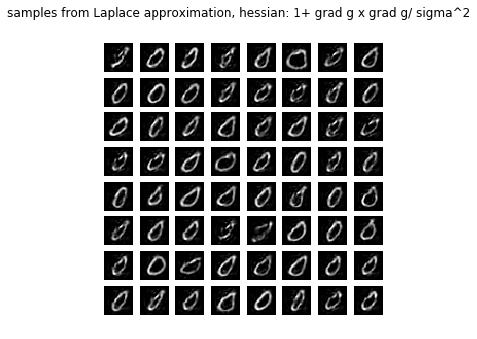

covariances
(1, 10, 10)


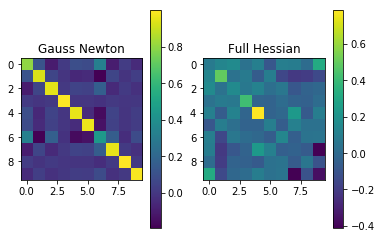

hessians
(1, 10, 10)


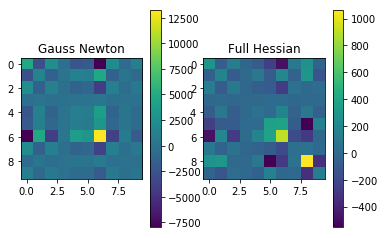

eigenvalues before and after inverse, full hessian
[array([[-1.1268183e+00,  1.0906180e+00,  1.4021558e+00,  2.0153701e+00,
         2.7553127e+00,  6.4099560e+00,  1.6324356e+01,  3.1065311e+01,
         1.1323862e+03,  1.9428584e+03]], dtype=float32), array([[-8.87429432e-01,  5.14705560e-04,  8.83091079e-04,
         3.21902366e-02,  6.12584906e-02,  1.56007759e-01,
         3.62934284e-01,  4.96166176e-01,  7.13209347e-01,
         9.16922991e-01]])]
1
full hessian fails


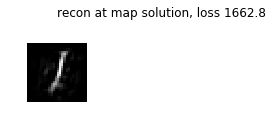

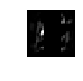

eigenvalues before and after inverse, approx hessian
[array([[  0.9999625 ,   0.9999929 ,   0.9999993 ,   0.99999976,
          1.        ,   1.0000006 ,   1.000002  ,   1.000013  ,
          1.0000234 , 896.1658    ]], dtype=float32), array([[0.00111586, 0.99998177, 0.99998917, 0.99999572, 0.99999829,
        0.99999967, 1.        , 1.0000001 , 1.00000135, 1.00000652]])]


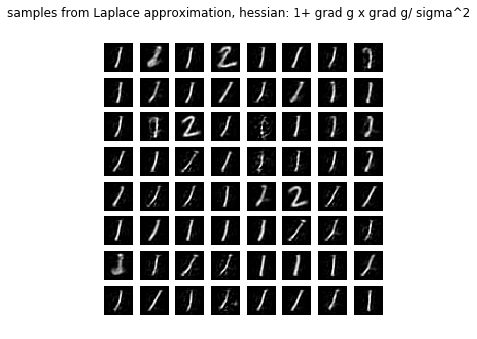

covariances
(1, 10, 10)


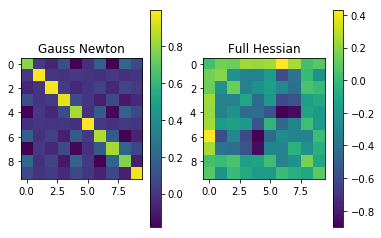

hessians
(1, 10, 10)


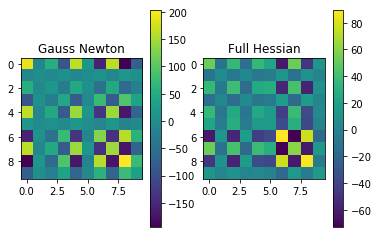

eigenvalues before and after inverse, full hessian
[array([[-1.0620868e+01, -3.3908921e-01,  9.0434611e-01,  1.7576675e+00,
         2.4122748e+00,  2.5508447e+00,  4.6136904e+00,  1.5420010e+01,
         3.1889263e+01,  3.4618149e+02]], dtype=float32), array([[-2.94904721e+00, -9.41543146e-02,  2.88865826e-03,
         3.13585054e-02,  6.48507989e-02,  2.16746185e-01,
         3.92028571e-01,  4.14550903e-01,  5.68929421e-01,
         1.10580374e+00]])]
1
full hessian fails


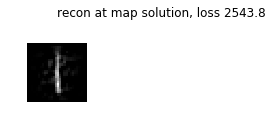

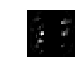

eigenvalues before and after inverse, approx hessian
[array([[  0.99998736,   0.99999774,   0.99999946,   0.9999997 ,
          1.0000002 ,   1.0000004 ,   1.0000005 ,   1.0000012 ,
          1.0000068 , 170.02522   ]], dtype=float32), array([[0.00588148, 0.999998  , 0.99999846, 0.99999968, 0.99999993,
        1.00000005, 1.0000003 , 1.00000062, 1.00000163, 1.00000227]])]


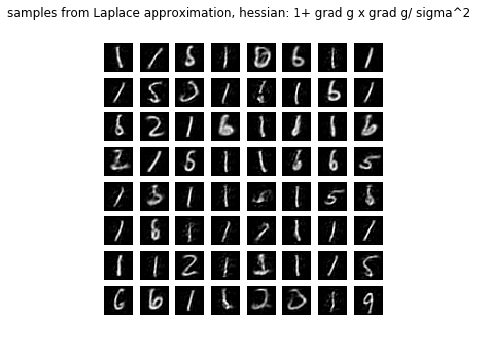

covariances
(1, 10, 10)


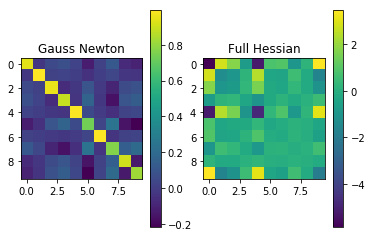

hessians
(1, 10, 10)


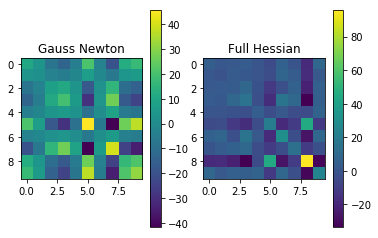

eigenvalues before and after inverse, full hessian
[array([[-1.2366663e+01, -3.7152350e+00, -1.2248390e+00, -6.6501804e-02,
         3.6574836e+00,  5.1539078e+00,  7.9090075e+00,  2.5797215e+01,
         2.9887295e+01,  1.6225391e+02]], dtype=float32), array([[-1.50367900e+01, -8.16433527e-01, -2.69161625e-01,
        -8.08625283e-02,  6.16318111e-03,  3.34590335e-02,
         3.87638813e-02,  1.26438041e-01,  1.94027539e-01,
         2.73412270e-01]])]
1
full hessian fails


In [64]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis = [] 
# order minima by loss function value
l_minima   = np.asarray(l_minima)
map_minima = np.asarray(map_minima)
order      = np.argsort(l_minima)


# go through minima
for ii,ini_ in enumerate(map_minima[order]):
  
  
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(likeli_MAP.mean(),feed_dict={x_corr: data, sigma_corr:sigma_new})
  
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:False})
  

  figure(figsize=(5,5))
  if ii==0:
    suptitle('recon at map solution, loss %.1f; start from truth'%l_minima[ii])
  else:
    suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()

  # get diagonal
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})]
  
  print('eigenvalues before and after inverse, approx hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False}))

  # get samples 
  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  figure(figsize=(5,5))
  suptitle('samples from Laplace approximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  
  
  ## plot sigma
  print('covariances')
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  print('hessians')
  sigma_m = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True}))
  try:
    for s in [1]:
      print(s)
   
      _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      figure(figsize=(5,5))
      suptitle('samples from Laplace approximation, full hessian')
      for i in range(sample_size_z):
          subplot(8,8,i+1)
          imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
          axis('off')
      plt.show()
      
    print('diagonal approx')
    _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:1, diag_hess:True})

    l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, diag_hess:True})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian diagonal')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
    print('hessian successful',ii)
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')


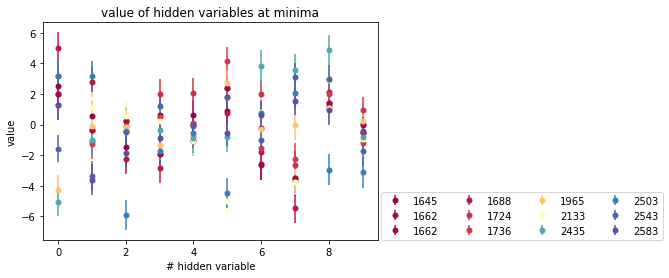

In [65]:
# check if minima are distinct
order = np.argsort(l_minima)
map_minima = np.asarray(map_minima[order])
l_minima   = np.asarray(l_minima[order])
varis      = np.asarray(varis)

colors = matplotlib.colors.Normalize(vmin=min(l_minima), vmax=max(l_minima))
cmap = matplotlib.cm.get_cmap('Spectral')

plt.title('value of hidden variables at minima')
for ii in range(len(map_minima)):
  yerr_= np.sqrt(varis[ii,0])

  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima[ii]), marker='o',ls='', c=cmap(colors(l_minima[ii])), mew=0, yerr=yerr_, label ='%d'%l_minima[ii])
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.savefig(plot_path+'minima_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

**explore posterior around minima**

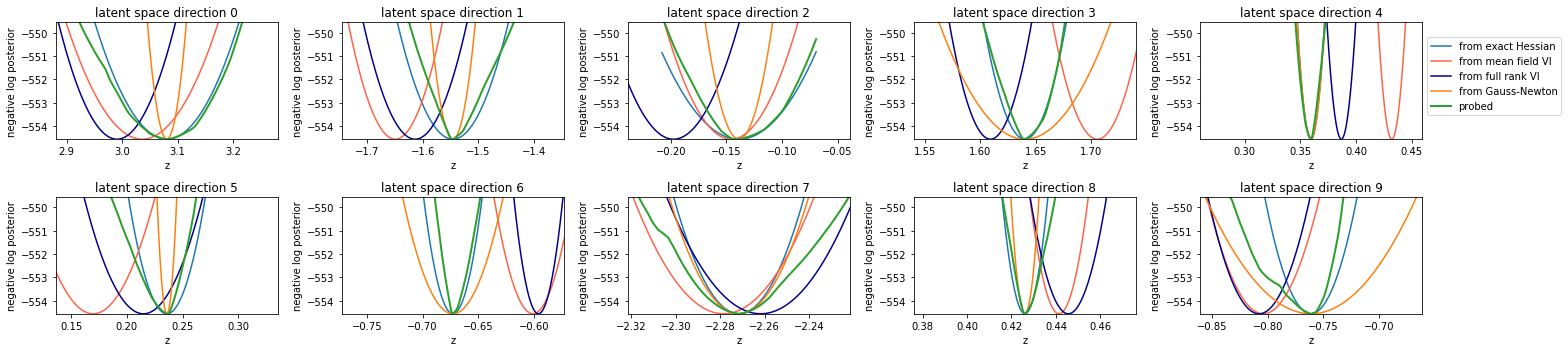

In [61]:
order     = np.argsort(l_minima)[3]

# testing Hessian
for ii,ini_ in enumerate([map_minima[order]]):
  
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True})
  measured_hessian = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  GN_hessian = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  ll0 = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B    = measured_hessian[0,nn,nn]
    GN   = GN_hessian[0,nn,nn]
    VIm  = np.linalg.inv(VI_cov)[0,nn,nn]

    z_VI  = (0.001*(np.arange(1001)-501))*VI_mean[0,nn]
    
    VImf  = np.linalg.inv(VI_f_cov)[0,nn,nn]

    z_VIf = (0.001*(np.arange(1001)-501))*VI_f_mean[0,nn]

    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(1001):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.001*(jj-501))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      ll = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      losses.append(-ll)
      

    
    
    plt.plot(ini_[0][:,nn]+(0.001*(np.arange(1001)-501))*ini_[0][:,nn],-ll0+B*((0.001*(np.arange(1001)-501))*ini_[0][:,nn])**2,label='from exact Hessian')
    plt.plot(z_VI+VI_mean[0,nn],-ll0+VIm*z_VI**2,label='from mean field VI', color='tomato')
    plt.plot(z_VIf+VI_f_mean[0,nn],-ll0+VImf*z_VIf**2,label='from full rank VI', color='darkblue')
    plt.plot(ini_[0][:,nn]+(0.001*(np.arange(1001)-501))*ini_[0][:,nn],-ll0+GN*((0.001*(np.arange(1001)-501))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    plt.plot(ini_[0][:,nn]+(0.001*(np.arange(1001)-501))*ini_[0][:,nn],losses,label='probed', lw=2)
    
    
    plt.xlabel('z')
    plt.ylabel('negative log posterior')
    plt.ylim(-ll0,-ll0+5)
    if nn in [0,1]:
      plt.xlim(ini_[0][:,nn]-0.2, ini_[0][:,nn]+0.2)
    elif nn in [2,3,4,5,6,9]:
      plt.xlim(ini_[0][:,nn]-0.1, ini_[0][:,nn]+0.1)
    elif nn in [7,8]:
      plt.xlim(ini_[0][:,nn]-0.05, ini_[0][:,nn]+0.05)
  plt.tight_layout()
  plt.legend(loc=(1.02,1.7))
  
  
  
  plt.savefig(plot_path+'probing_posterior_xmin%d_xmax%d_noVI_start0_rescaled.png'%(minx,maxx),bbox_inches='tight')


**Build Gaussian Mixture Model**

In [71]:
mu_     =[]
sigma_  =[]
w_tilde =[]
#diag    =[]

order   = np.argsort(l_minima)
mus     = map_minima[[order[ii] for ii in [0,3,4,7]]]
# loop over components, start with lowest, go higher and higher
for ii in range(num_comp):
  
  # do Laplace approximation around this minimum
  print(sess.run(MAP_reset,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]}))
  mu_+=[sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]})]
  sigma_+=[sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})]
  

  #diag+=[sess.run(lapl_variance_MAP,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})]
  logdet_ = sess.run(log_det,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})
  logprob = sess.run(posterior_MAP,feed_dict={x_corr: data, sigma_corr:sigma_new})
  print(logdet_,logprob,0.5*logdet_+logprob)
  w_tilde+=[np.exp(0.5*(logdet_+logprob))]

mu_    = np.reshape(np.asarray(mu_),[1,num_comp,hidden_size])
sigma_ = np.reshape(np.asarray(sigma_),[1,num_comp,hidden_size,hidden_size])

w_tilde= np.asarray(w_tilde)
print(w_tilde)

A = 1./np.sum(w_tilde)

w = w_tilde*A
w = np.squeeze(w)
print(w)


_=sess.run(update_a,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_b,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_c,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })



[[ 2.5158231   0.54948133 -1.4606208   0.6180156   0.6142714   0.8875758
  -0.2298886  -3.6828494   1.2015607  -0.5029857 ]]
[-39.17159542] [-1645.8801] [-1665.46592466]
[[ 5.0333667   2.762249   -2.2554455  -2.8095922   0.04207811  0.7824497
  -1.7884051  -5.4321127   2.1311734  -0.527466  ]]
[-34.3613973] [-1688.6383] [-1705.81900432]
[[ 3.1723146  -1.037266   -0.39281884  1.9793112   2.050941    1.8251923
   2.0126882  -2.6667345   1.0988084   0.9646533 ]]
[-39.49252328] [-1724.303] [-1744.04924015]
[[-1.620956    1.1187712   0.5725422   0.21433648 -1.0460218  -4.961221
   0.81510174 -3.746994    1.117568   -0.9190133 ]]
[-26.70456487] [-2133.176] [-2146.52830783]
[[0.]
 [0.]
 [0.]
 [0.]]
[nan nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply


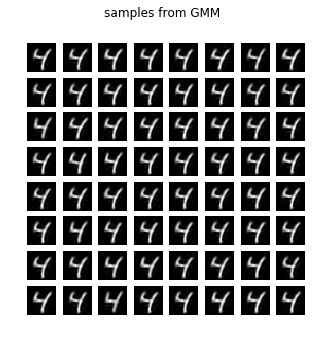

In [69]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={x_corr: data, sigma_corr:sigma_new})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

**minima without nvp**

0
3890.3364
1959.1981
1959.5992
1959.0587
1958.3679
1958.3707
1958.4031
1958.424
1958.5094
1958.3202
1
2347.845
714.1892
715.21533
714.8303
713.9297
713.984
714.03064
713.88574
713.98016
713.7779
2
2684.6426
720.0725
720.7534
720.01984
719.5433
719.5436
719.5537
719.5471
719.5503
719.543
3
2544.466
715.8527
716.9342
714.77466
713.877
713.97455
713.9258
713.84827
713.9603
713.7777
4
2498.1372
1425.5186
1425.5586
1425.1626
1424.1106
1424.0955
1424.1638
1424.2406
1424.1365
1424.0698
5
1495.8269
721.3124
721.76624
721.59576
721.20325
721.2087
721.22675
721.1926
721.2185
721.17834
6
2995.2068
715.0438
714.2657
714.765
713.94763
713.83673
713.8225
714.0238
713.9539
713.7776
7
2245.8762
723.0961
722.8054
722.80585
722.4314
722.4642
722.47125
722.4327
722.4555
722.40546
8
2918.7454
1366.9164
1369.682
1365.2465
1364.7677
1364.7737
1364.6284
1364.7498
1364.9977
1364.4554
9
3899.258
720.5413
721.1754
720.9077
719.544
719.5429
719.5466
719.54803
719.55084
719.5427


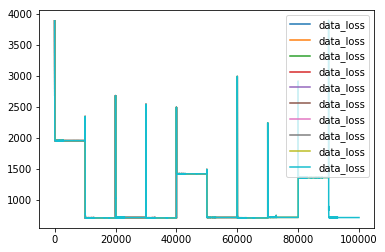

In [38]:
l_minima_old=[]
map_minima_old=[]
posterior_loss3=[]
for ii in range(10):
  print(ii)
  ini = np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, nvp_prior: False, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(3000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  for ii in range(5000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-4
  for ii in range(2000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  l_minima_old+=[ll]
  map_minima_old+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior: False, lr:lrate})]
  plot(posterior_loss3,label='data_loss')
  legend()

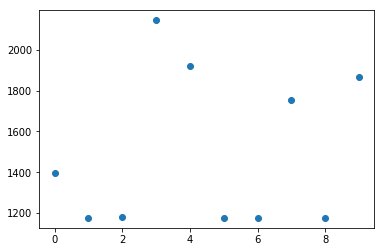

In [23]:
plt.figure()
plt.plot(np.arange(10),l_minima_old,ls='',marker='o')
plt.show()

In [125]:
import pickle
try:
  l_minima_old,map_minima_old = pickle.load(open(minima_path+'nvp_minima_nonnvp_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([l_minima_old,map_minima_old],open(minima_path+'nvp_minima_nonnvp_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))
  
map_minima_old = np.asarray(map_minima_old)
l_minima_old  = np.asarray(l_minima_old)

print(map_minima_old)

[[[[-0.7923539   1.5970947   1.5343508   0.04641243 -0.780231
    -0.6863949   1.1647897   0.31511375  1.1303812   0.3975146 ]]]


 [[[ 1.4395659  -0.05169467 -0.9570933  -0.22535267  1.7277365
    -0.51103675  0.05222924 -1.4663507   0.565135    1.2672961 ]]]


 [[[ 1.3863779  -0.46198204 -0.8511998  -0.25305322  1.686109
    -0.34971595  0.01644781 -1.5385765   0.6641998   0.95052224]]]


 [[[ 1.4395248  -0.0516899  -0.9570636  -0.22538324  1.7277769
    -0.5111041   0.05225403 -1.4663287   0.5651562   1.2672976 ]]]


 [[[ 0.43194094  0.22845057 -1.2477007  -0.35619962  1.5260986
    -0.22716324  1.4763312  -0.74448305  0.99762946 -0.26632553]]]


 [[[ 1.4682012  -0.23448974 -0.55505043 -0.24510293  1.6650419
    -0.37470245  0.17325807 -1.255145    0.59373885  1.3508488 ]]]


 [[[ 1.4396101  -0.05173619 -0.957069   -0.22538015  1.7276957
    -0.51101834  0.05218298 -1.4663926   0.56509984  1.267332  ]]]


 [[[ 1.4241133  -0.3957534  -0.57334936 -0.2593581   1.6363993
    -0.40029195

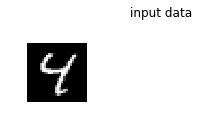

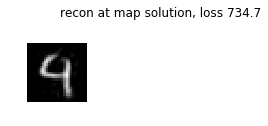

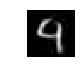

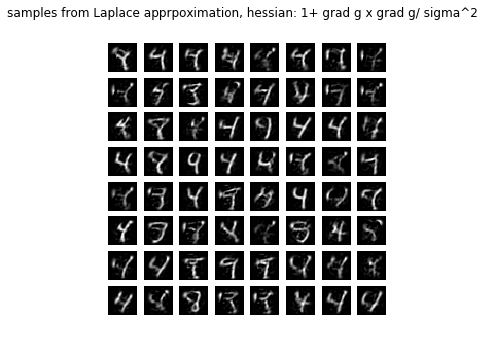

<Figure size 360x360 with 0 Axes>

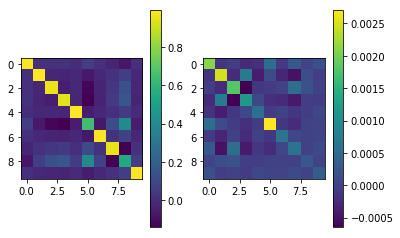

eigenvalues before and after inverse, full hessian
[array([[ 295.56754,  323.79993,  499.59866,  548.0393 , 1303.2059 ,
        1928.2512 , 2408.4624 , 2883.6624 , 4263.6104 , 6316.3467 ]],
      dtype=float32), array([[0.00015832, 0.00023454, 0.00034678, 0.0004152 , 0.0005186 ,
        0.00076734, 0.00182469, 0.00200161, 0.00308833, 0.00338332]])]


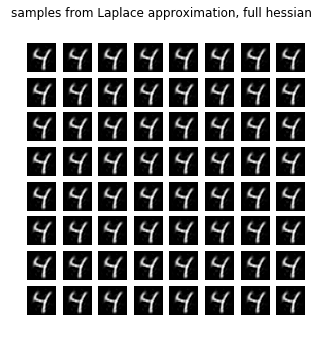

3668.8733
4529.705
3326.061
3351.1743
4875.9985
2776.5168
2532.6074
1941.6797
3053.084
3832.9746
2146.8596
3008.916
3297.4705
2859.096
3381.3179
3247.8804
2240.019
3554.5134
2462.25
3506.1858


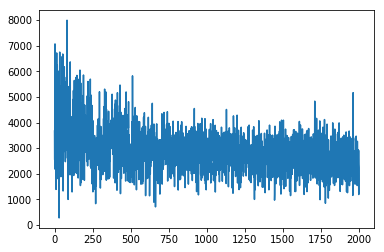

variance of VI [[-1.2170253   1.7620015   0.09897376 -1.8091397  -1.097841   -0.9518143
  -0.98718333 -0.13389398 -2.072787   -1.2791116 ]]


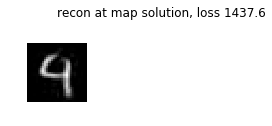

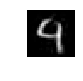

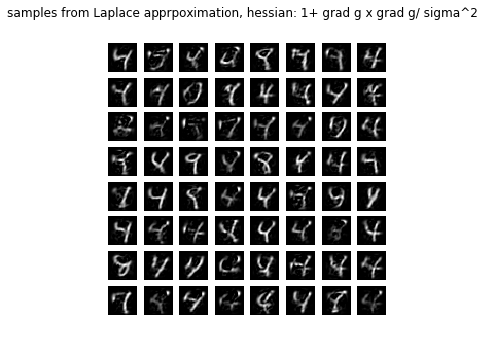

<Figure size 360x360 with 0 Axes>

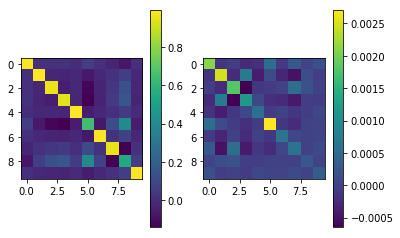

eigenvalues before and after inverse, full hessian
[array([[ 295.56754,  323.79993,  499.59866,  548.0393 , 1303.2059 ,
        1928.2512 , 2408.4624 , 2883.6624 , 4263.6104 , 6316.3467 ]],
      dtype=float32), array([[0.00015832, 0.00023454, 0.00034678, 0.0004152 , 0.0005186 ,
        0.00076734, 0.00182469, 0.00200161, 0.00308833, 0.00338332]])]


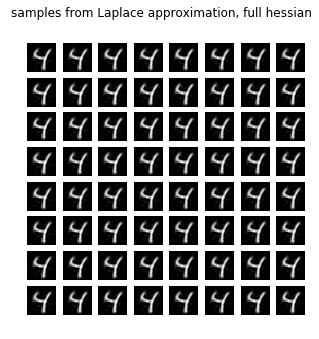

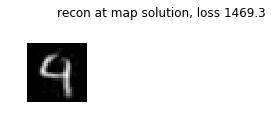

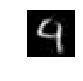

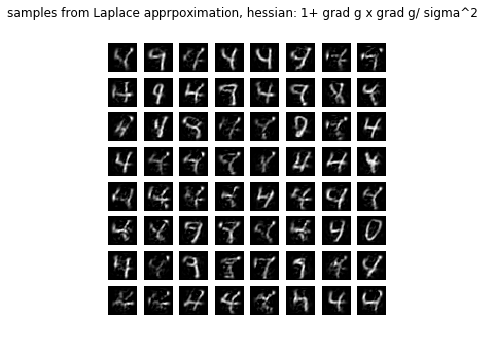

<Figure size 360x360 with 0 Axes>

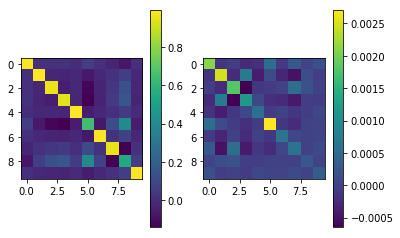

eigenvalues before and after inverse, full hessian
[array([[ 295.56754,  323.79993,  499.59866,  548.0393 , 1303.2059 ,
        1928.2512 , 2408.4624 , 2883.6624 , 4263.6104 , 6316.3467 ]],
      dtype=float32), array([[0.00015832, 0.00023454, 0.00034678, 0.0004152 , 0.0005186 ,
        0.00076734, 0.00182469, 0.00200161, 0.00308833, 0.00338332]])]


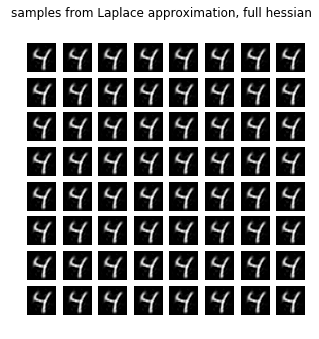

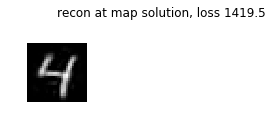

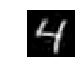

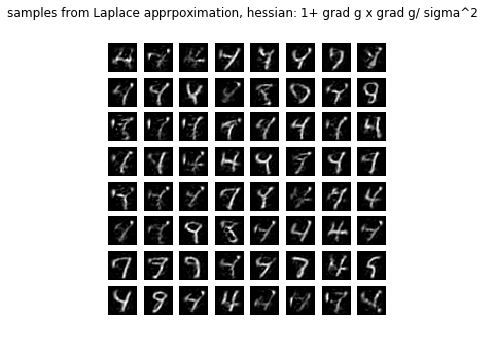

<Figure size 360x360 with 0 Axes>

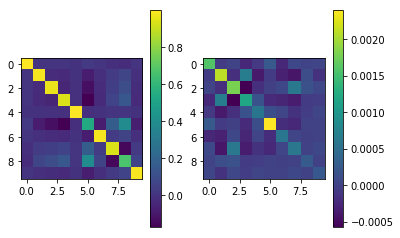

eigenvalues before and after inverse, full hessian
[array([[ 329.25522,  390.76392,  505.37305,  642.30615, 1251.9392 ,
        2089.7246 , 3148.4846 , 4194.1494 , 4512.867  , 5780.151  ]],
      dtype=float32), array([[0.00017301, 0.00022159, 0.00023843, 0.00031761, 0.00047853,
        0.00079876, 0.00155689, 0.00197874, 0.00255909, 0.00303716]])]


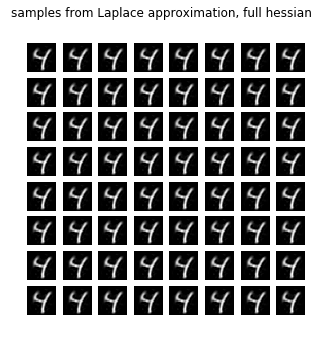

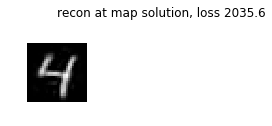

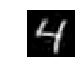

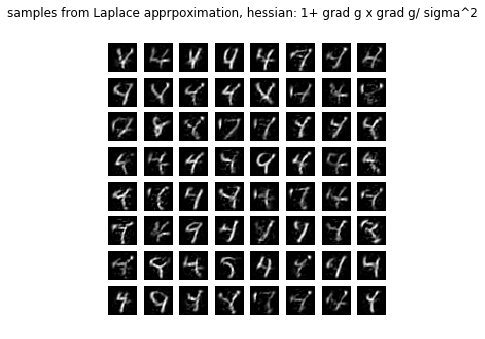

<Figure size 360x360 with 0 Axes>

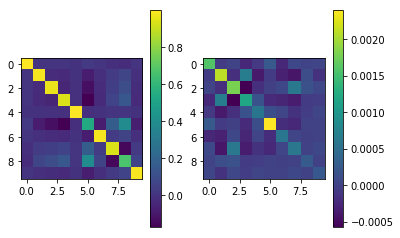

eigenvalues before and after inverse, full hessian
[array([[ 329.25522,  390.76392,  505.37305,  642.30615, 1251.9392 ,
        2089.7246 , 3148.4846 , 4194.1494 , 4512.867  , 5780.151  ]],
      dtype=float32), array([[0.00017301, 0.00022159, 0.00023843, 0.00031761, 0.00047853,
        0.00079876, 0.00155689, 0.00197874, 0.00255909, 0.00303716]])]


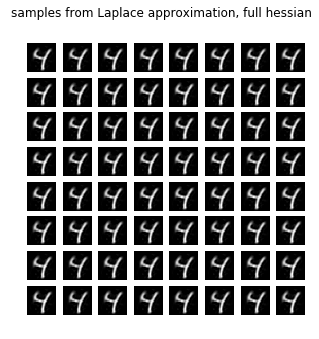

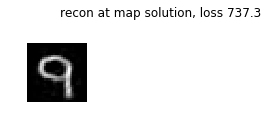

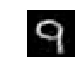

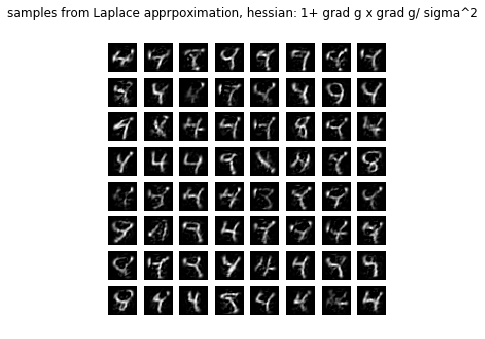

<Figure size 360x360 with 0 Axes>

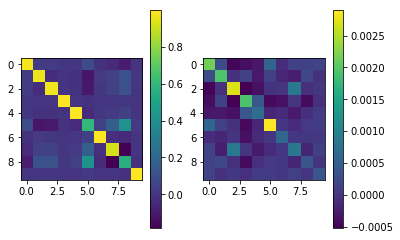

eigenvalues before and after inverse, full hessian
[array([[ 279.96597,  295.79144,  472.9282 ,  497.15036,  622.2537 ,
        1505.4579 , 1954.3016 , 2864.6968 , 4806.72   , 5976.8223 ]],
      dtype=float32), array([[0.00016731, 0.00020804, 0.00034908, 0.00051169, 0.00066425,
        0.00160706, 0.00201146, 0.00211449, 0.00338076, 0.00357186]])]


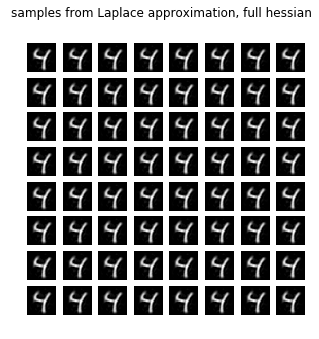

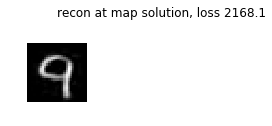

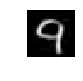

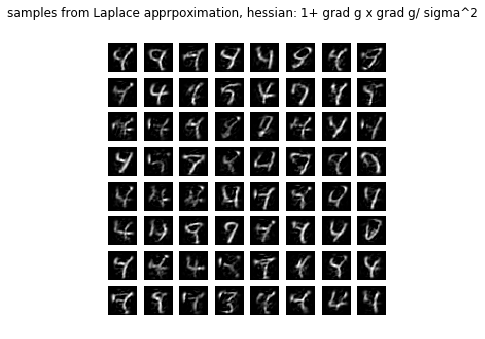

<Figure size 360x360 with 0 Axes>

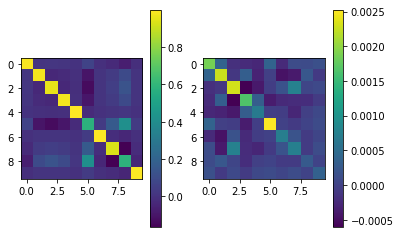

eigenvalues before and after inverse, full hessian
[array([[ 302.79645,  340.4805 ,  404.1211 ,  606.9125 ,  821.4269 ,
        1518.1434 , 1977.6283 , 2930.4229 , 5448.519  , 5482.971  ]],
      dtype=float32), array([[0.00018238, 0.00018354, 0.00034125, 0.00050566, 0.0006587 ,
        0.00121739, 0.00164768, 0.00247451, 0.00293702, 0.00330255]])]


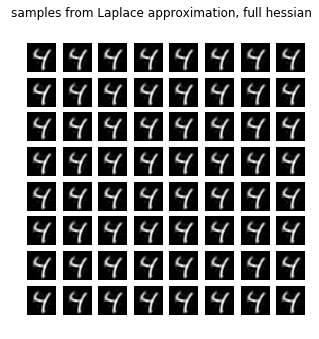

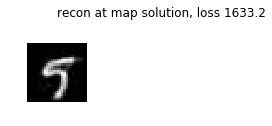

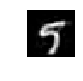

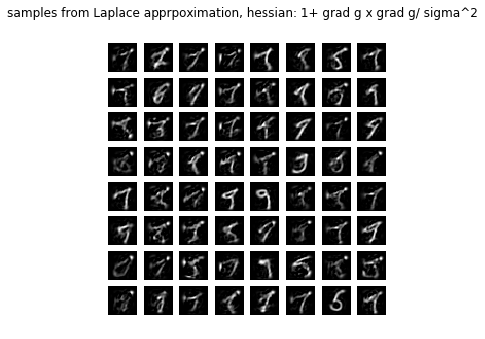

<Figure size 360x360 with 0 Axes>

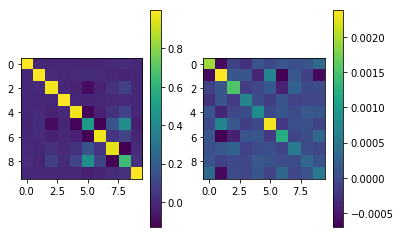

eigenvalues before and after inverse, full hessian
[array([[ 270.0749 ,  447.03912,  562.2821 ,  678.5729 , 1258.5518 ,
        1302.7478 , 1665.9392 , 2242.6946 , 3181.356  , 4399.3623 ]],
      dtype=float32), array([[0.00022731, 0.00031433, 0.00044589, 0.00060026, 0.00076761,
        0.00079456, 0.00147368, 0.00177847, 0.00223694, 0.00370268]])]


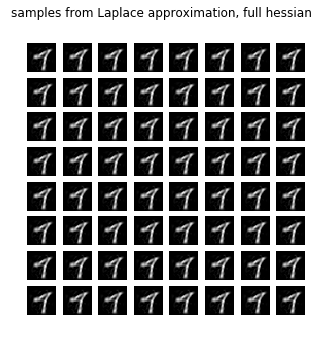

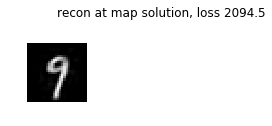

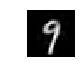

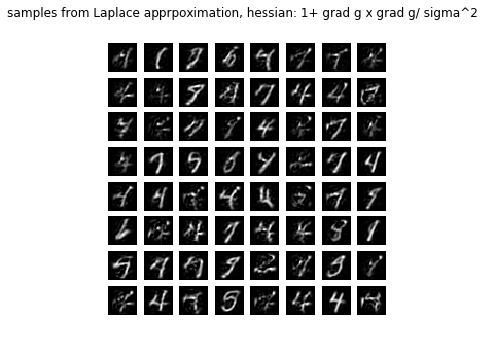

<Figure size 360x360 with 0 Axes>

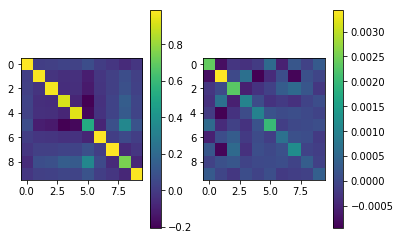

eigenvalues before and after inverse, full hessian
[array([[ 215.7159 ,  327.37067,  412.52216,  574.13824, 1279.0986 ,
        1365.5774 , 1837.0723 , 3068.643  , 3292.8608 , 4329.6123 ]],
      dtype=float32), array([[0.00023097, 0.00030369, 0.00032588, 0.00054434, 0.00073229,
        0.0007818 , 0.00174174, 0.00242411, 0.00305464, 0.00463573]])]


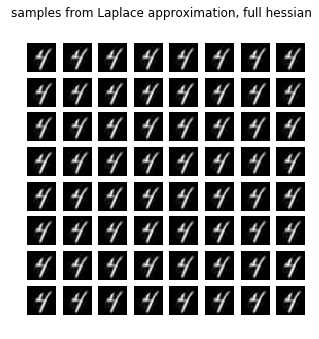

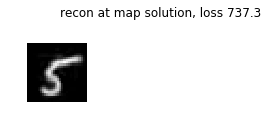

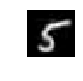

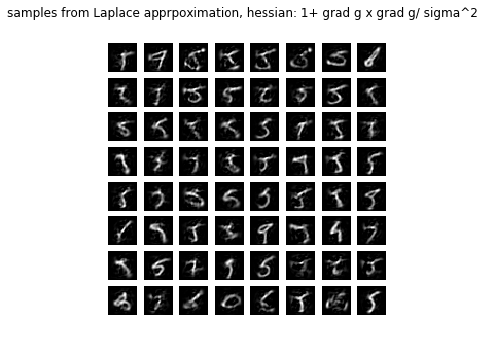

<Figure size 360x360 with 0 Axes>

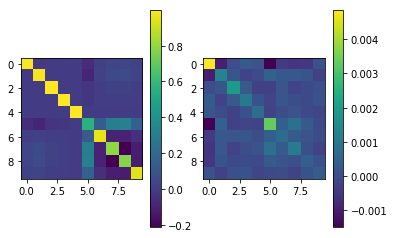

eigenvalues before and after inverse, full hessian
[array([[ 156.86053,  374.12003,  476.10394,  776.0871 ,  787.6871 ,
        1338.9464 , 1551.5988 , 2042.3889 , 3118.9053 , 5684.9727 ]],
      dtype=float32), array([[0.0001759 , 0.00032063, 0.00048962, 0.0006445 , 0.00074686,
        0.00126954, 0.00128851, 0.00210038, 0.00267294, 0.0063751 ]])]


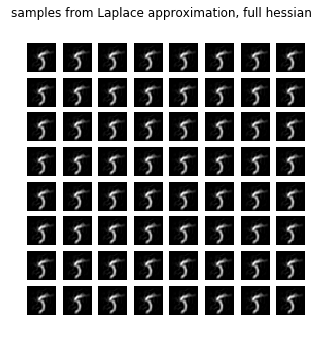

In [128]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

#order minimia
varis=[] 
l_minima_old=np.asarray(l_minima_old)
map_minima_old=np.asarray(map_minima_old)
order = np.argsort(l_minima_old)


for ii,ini_ in enumerate(map_minima_old[order]):
  
  # set MAP
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new, nvp_prior:False})
  mean_at_map = sess.run(likeli_MAP.mean(),feed_dict={x_corr: data, sigma_corr:sigma_new})
  
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
 
  # Laplace approximation
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior:False})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})]

  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  
  figure(figsize=(5,5))
  suptitle('samples from Laplace apprpoximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  figure(figsize=(5,5))
  #mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))

  ## plot sigma
  
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})

  plt.figure()
  subplot(1,2,1)
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
    
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False}))
  try:
    _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})

    l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
  
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')


#do vae on corrupted data with mean of posterior set to MAP values
  if ii ==0:
    _ = sess.run(update4,feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior: False})   
    lrate=1e-2
    elbo_2_loss=[]
    for ii in range(2000):
      _, ll = sess.run([opt_op_elbo2, elbo],feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior: False})
      elbo_2_loss.append(ll)
      if ii%100==0:
        print(ll)
    plt.figure()
    plt.plot(elbo_2_loss)
    plt.show()
    
    elbo_var = sess.run(sigma_elbo,feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior: False})
    print('variance of VI', elbo_var)    


(1, 10, 10)


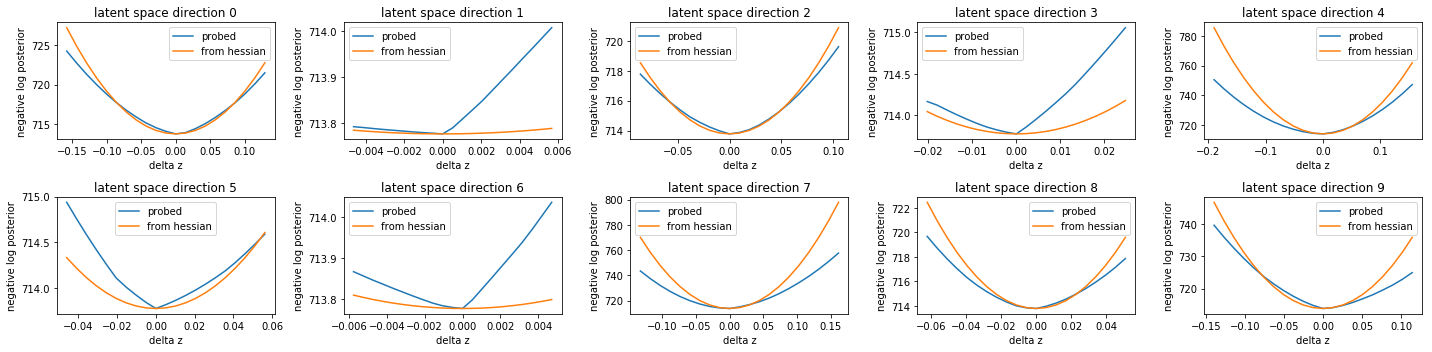

In [0]:
order     = np.argsort(l_minima_old)[0]
# testing Hessian
for ii,ini_ in enumerate([map_minima_old[order]]):
  
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], nvp_prior:False})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True, nvp_prior:False})
  measured_hessian = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior:False})
  GN_hessian = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  print(GN_hessian.shape)
  ll0 = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new, nvp_prior:False})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B = measured_hessian[0,nn,nn]
    GN = GN_hessian[0,nn,nn]
    elbo_v = 1./elbo_var[0,nn]**2
    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(21):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.01*(jj-11))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new, nvp_prior:False})
      ll = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new, nvp_prior:False})
      losses.append(-ll)
    plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],losses,label='probed')
    plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+B*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from hessian')
    #plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+elbo_v*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from VI', color='tomato')
    #plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+GN*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    plt.legend()
    plt.xlabel('delta z')
    plt.ylabel('negative log posterior')
    plt.tight_layout()


W0505 20:45:53.899823 140256009533312 legend.py:1289] No handles with labels found to put in legend.


(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)


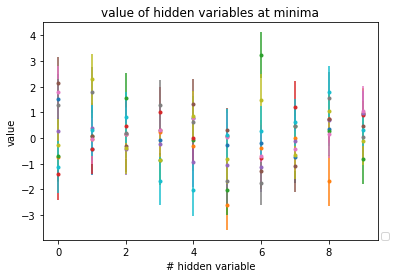

In [0]:
varis=np.asarray(varis)
map_minima_old=np.asarray(map_minima_old)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima_old)):
  print(map_minima_old.shape)
  yerr_= np.sqrt(varis[ii,0])
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima_old[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

**do vae on corrupted data with mean of posterior set to MAP values**

---

